## Personal Activity Tracking Data Analysis
### by Ivaylo Pavlov (22/10/2016)
##### Data from iPhone (25/09/2015 - 11/03/2016) & Garmin Vivosmart HR (11/03/2016 - Present) exported using QS Access App

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.patches as mpatches, warnings, seaborn as sns, scipy.stats as ss, matplotlib.mlab as mlab
warnings.filterwarnings('ignore')

%pylab inline
plt.rc("savefig", dpi=200)
matplotlib.style.use('ggplot')

pd.set_option('display.max_colwidth',80)

Populating the interactive namespace from numpy and matplotlib


#### Import and clean the daily data and transform the heart rate intraday data for use

In [2]:
#Import the CSV files with the daily and intraday data
raw_daily_data = pd.read_csv("Health Data-daily.csv")
raw_intraday_data = pd.read_csv('Health Data-intraday.csv')

#Extract only the heart rate from the intraday data and the delete the rest, add a day only column
raw_intraday_data.index = raw_intraday_data['Start']
raw_intraday_data = raw_intraday_data.ix[:,'Heart Rate (count/min)']
raw_intraday_data = pd.DataFrame(raw_intraday_data)
raw_intraday_data.index = pd.to_datetime(raw_intraday_data.index)
raw_intraday_data = raw_intraday_data.ix[raw_intraday_data.index>'11-Mar-2016 18:00']
raw_intraday_data = raw_intraday_data.replace(0, np.nan)
raw_intraday_data = raw_intraday_data.dropna(axis=0)
raw_intraday_data['Date'] = raw_intraday_data.index.date
hr_intraday = raw_intraday_data

#### Delete all the zero columns, set table index and delete the useless columns and add Total Calories and Weekday columns to DataSet

In [3]:
data = raw_daily_data.ix[:, (raw_daily_data != 0).any(axis=0)]
data = data.set_index(pd.DatetimeIndex(data['Start']))
data = data.drop(['Start','Finish'],axis=1)

data['Total Calories (kcal)'] = data['Active Calories (kcal)'] + data['Resting Calories (kcal)']
data['Weekday'] = data.index.dayofweek
days = {0:'0 Mon',1:'1 Tue',2:'2 Weds',3:'3 Thurs',4:'4 Fri',5:'5 Sat',6:'6 Sun'}
data['Weekday'] = data['Weekday'].apply(lambda x: days[x])

In [4]:
#Get table stats - rows and columns
print "ROWS OF DATA / DAILY: " + str(raw_daily_data.shape[0]) + " / INTRADAY: " + str(hr_intraday.shape[0])
print ""
data.tail(7)

ROWS OF DATA / DAILY: 393 / INTRADAY: 3166



,Active Calories (kcal),Body Fat Percentage (%),Body Mass Index (count),Distance (km),Flights Climbed (count),Heart Rate (count/min),Lean Body Mass (kg),Resting Calories (kcal),Steps (count),Weight (kg),Total Calories (kcal),Weekday
2016-10-15,930.0,0.000,0.0,4.050,5.598425,138.0,0.000000,1848.0,5062.0,0.000000,2778.0,5 Sat
2016-10-16,1282.0,0.112,17.6,0.610,0.000000,123.0,48.529201,1848.0,766.0,54.650002,3130.0,6 Sun
2016-10-17,1989.0,0.000,0.0,8.010,0.000000,152.0,0.000000,1848.0,10002.0,0.000000,3837.0,0 Mon
2016-10-18,1182.0,0.000,0.0,4.320,0.000000,153.0,0.000000,1848.0,5407.0,0.000000,3030.0,1 Tue
2016-10-19,2128.0,0.000,0.0,12.880,0.000000,152.0,0.000000,1848.0,15890.0,0.000000,3976.0,2 Weds
2016-10-20,1662.0,0.123,17.6,9.740,28.388780,166.0,47.761419,1848.0,12187.0,54.459999,3510.0,3 Thurs
2016-10-21,0.0,0.000,0.0,4.478,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,4 Fri


#### Clean up WEIGHT data, Fill previous values for the Weight-related data and remove starting NA rows (Weight, BMI, Body Fat %, Lean Body Mass)

In [5]:
data.ix[:,'Body Fat Percentage (%)'] *= 100 #Scale Body Fat Percentage (%) by 100
data.ix[:,'Weight (kg)'] = data.ix[:,'Weight (kg)'].replace(to_replace=0, method='ffill')
data.ix[:,'Body Fat Percentage (%)'] = data.ix[:,'Body Fat Percentage (%)'].replace(to_replace=0, method='ffill')
data.ix[:,'Body Mass Index (count)'] = data.ix[:,'Body Mass Index (count)'].replace(to_replace=0, method='ffill')
data.ix[:,'Lean Body Mass (kg)'] = data.ix[:,'Lean Body Mass (kg)'].replace(to_replace=0, method='ffill')
data_for_weight = data[np.isfinite(data['Weight (kg)'])]
data_for_weight = data_for_weight.ix[:,['Weight (kg)','Lean Body Mass (kg)','Body Fat Percentage (%)','Body Mass Index (count)']]
data_for_weight = data_for_weight.ix[data_for_weight.index>'2016-03-28']
print "Rows remaining with Weight data: " + str(len(data_for_weight))

Rows remaining with Weight data: 207


#### Clean up STEPS, FLIGHTS CLIMBED, DISTANCE data, Setting all days with less than 550 steps or less than 0.400 km as NaN (haven't worn the tracker or battery died)

In [6]:
print "Rows before clean up: " + str(len(data))
data_for_steps = data
data_for_steps.ix[data_for_steps.ix[:,'Steps (count)']<550,'Steps (count)'] = np.nan
data_for_steps.ix[data_for_steps.ix[:,'Distance (km)']<0.400,'Distance (km)'] = np.nan
data_for_steps = data_for_steps[np.isfinite(data_for_steps['Steps (count)'])]
data_for_steps = data_for_steps[np.isfinite(data_for_steps['Distance (km)'])]
print "Rows lost after clean up: " + " " + str(len(data)-len(data_for_steps.index))
print "Rows after clean up: " + " " + str(len(data_for_steps.index))
data_for_steps.tail()

Rows before clean up: 393
Rows lost after clean up:  52
Rows after clean up:  341


,Active Calories (kcal),Body Fat Percentage (%),Body Mass Index (count),Distance (km),Flights Climbed (count),Heart Rate (count/min),Lean Body Mass (kg),Resting Calories (kcal),Steps (count),Weight (kg),Total Calories (kcal),Weekday
2016-10-16,1282.0,11.2,17.6,0.61,0.00000,123.0,48.529201,1848.0,766.0,54.650002,3130.0,6 Sun
2016-10-17,1989.0,11.2,17.6,8.01,0.00000,152.0,48.529201,1848.0,10002.0,54.650002,3837.0,0 Mon
2016-10-18,1182.0,11.2,17.6,4.32,0.00000,153.0,48.529201,1848.0,5407.0,54.650002,3030.0,1 Tue
2016-10-19,2128.0,11.2,17.6,12.88,0.00000,152.0,48.529201,1848.0,15890.0,54.650002,3976.0,2 Weds
2016-10-20,1662.0,12.3,17.6,9.74,28.38878,166.0,47.761419,1848.0,12187.0,54.459999,3510.0,3 Thurs


#### Clean up CALORIES, WEEKDAY, HEART RATE (daily) data

In [7]:
data_for_cal = data
data_for_cal.ix[data_for_cal.ix[:,'Total Calories (kcal)']<0.1,['Total Calories (kcal)','Active Calories (kcal)','Resting Calories (kcal)']] = np.nan
data_for_cal = data[np.isfinite(data['Total Calories (kcal)'])]
data_for_cal = data_for_cal.ix[data_for_cal.index>'2016-03-11']
data_for_cal2 = data_for_cal.drop(['Body Fat Percentage (%)','Body Mass Index (count)','Lean Body Mass (kg)','Weight (kg)','Distance (km)','Flights Climbed (count)','Steps (count)','Weekday','Total Calories (kcal)','Heart Rate (count/min)'],axis=1)

data_for_weekday = data.drop(['Body Fat Percentage (%)','Body Mass Index (count)','Lean Body Mass (kg)','Weight (kg)'],axis=1)

data_for_hr = data[["Heart Rate (count/min)","Weekday"]].copy()
data_for_hr = data_for_hr.ix[data_for_hr["Heart Rate (count/min)"]>0]

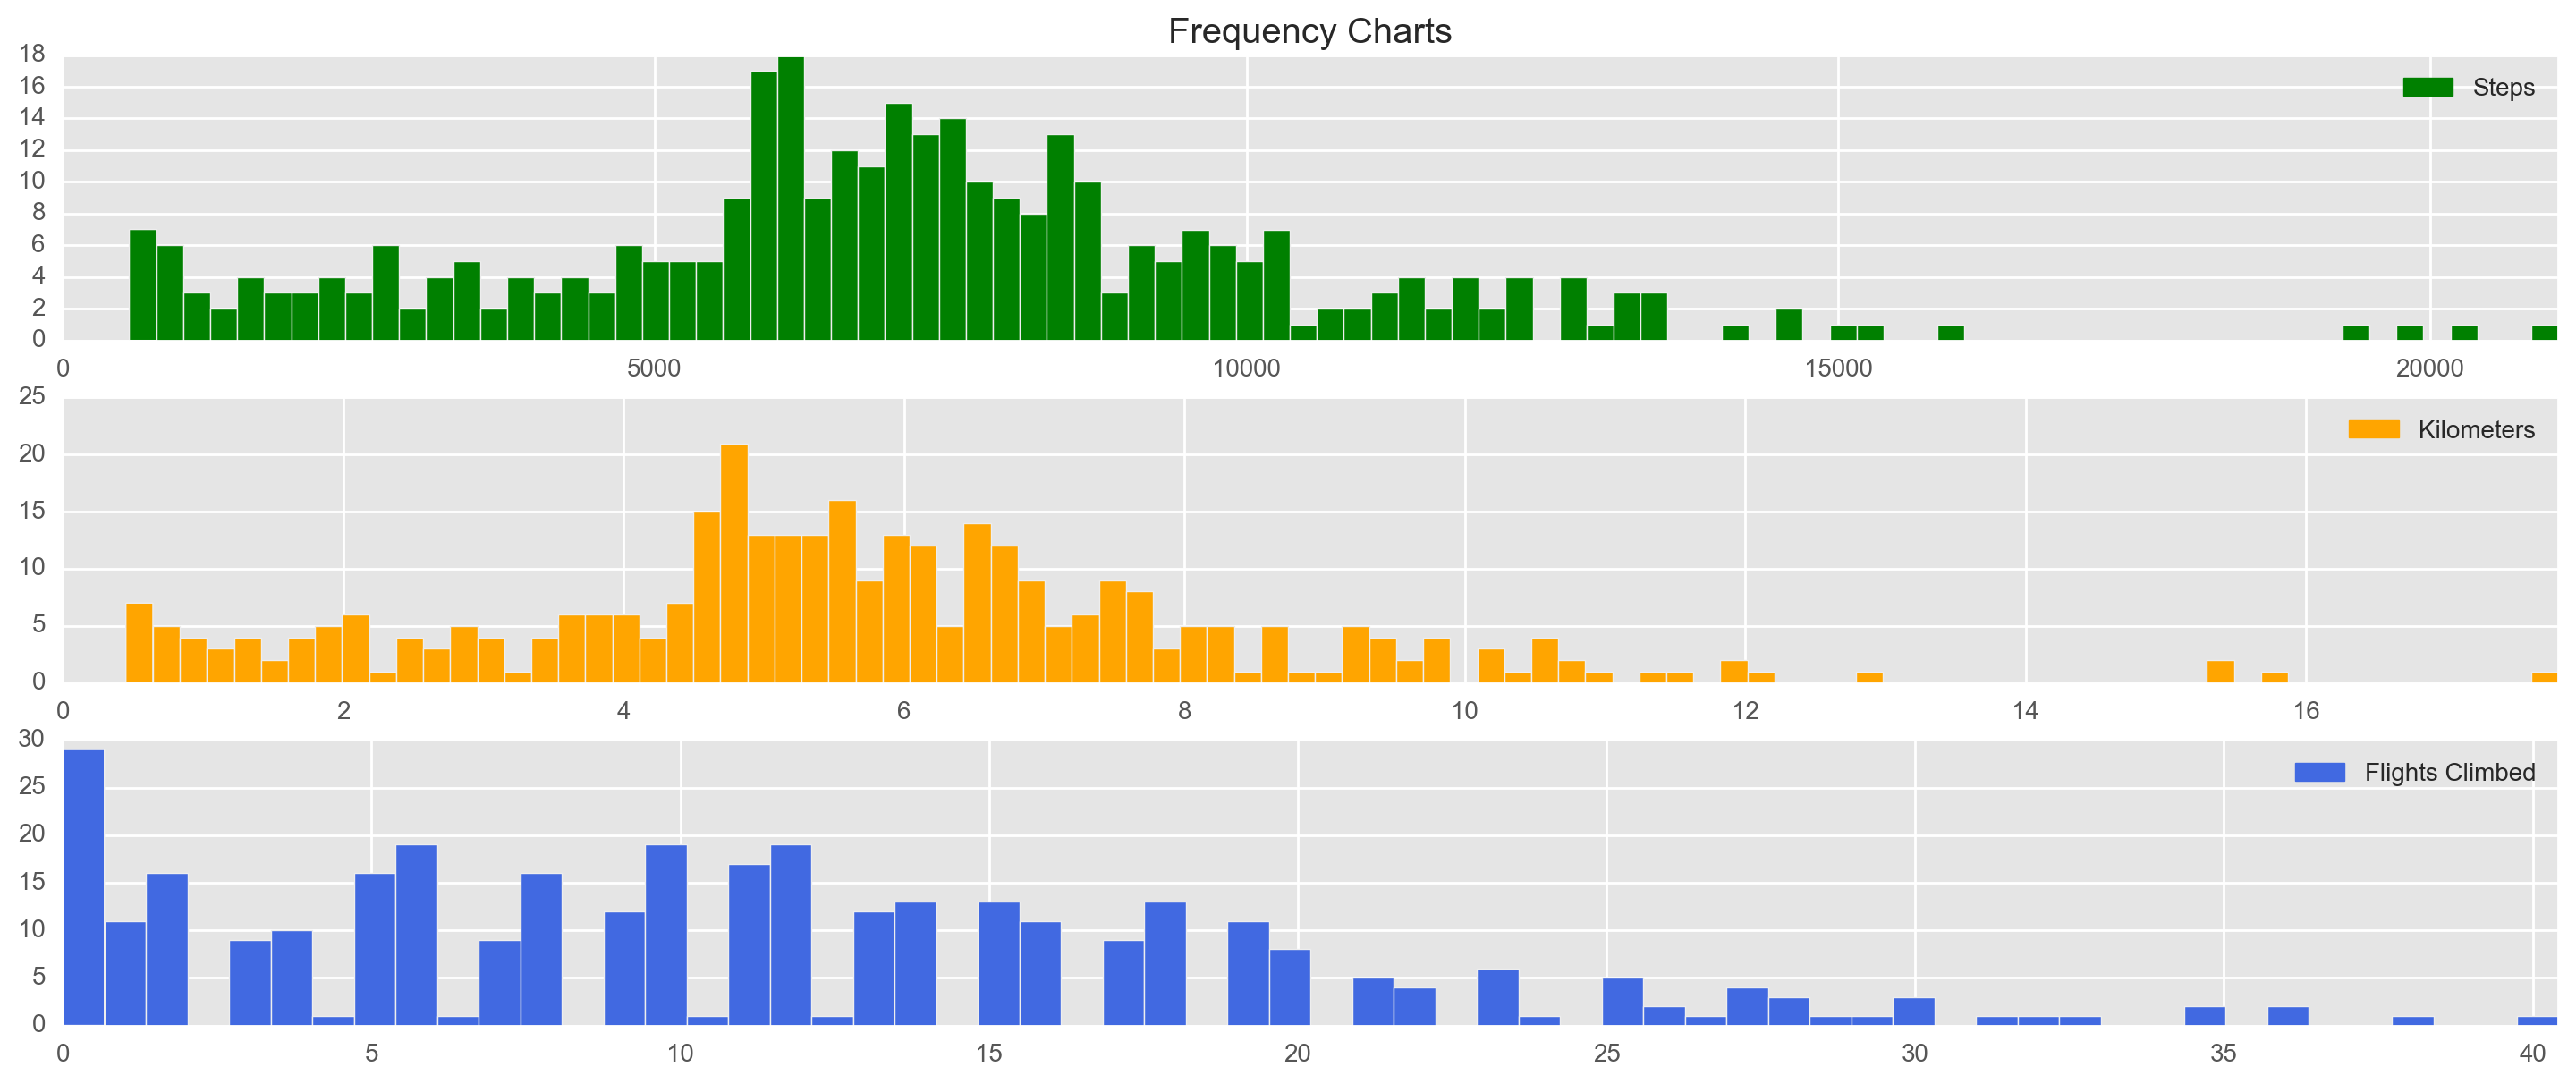

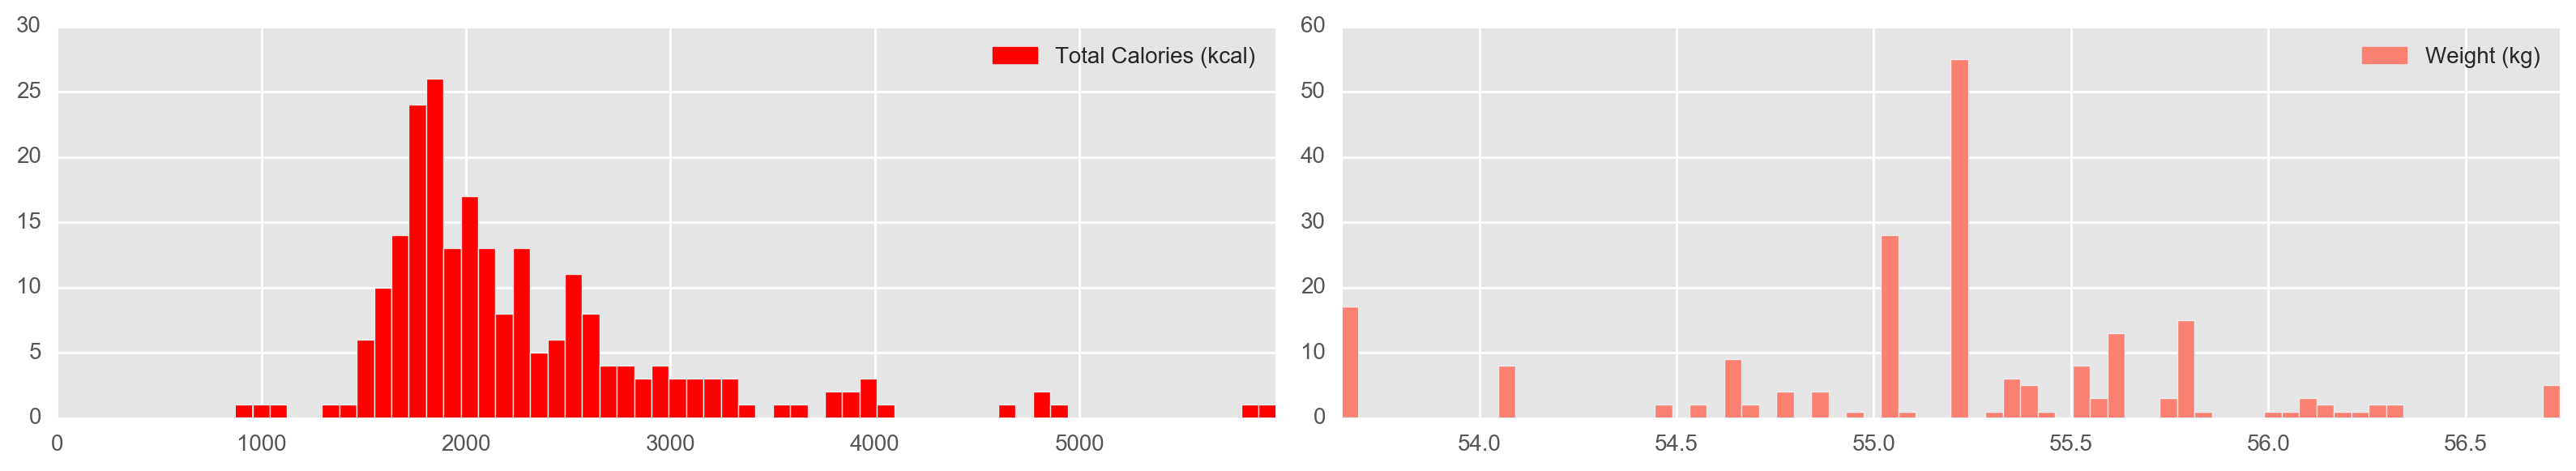

In [8]:
plt.figure(1,figsize=(18,7))

plt.subplot(311)
plt.title('Frequency Charts')
plt.legend(handles=[mpatches.Patch(color='green', label='Steps')])
plt.hist(data_for_steps.ix[:,'Steps (count)'], bins=90, color='g')
plt.xlim(0,data_for_steps.ix[:,'Steps (count)'].max())

plt.subplot(312)
plt.legend(handles=[mpatches.Patch(color='orange', label='Kilometers')])
plt.hist(data_for_steps.ix[:,'Distance (km)'], bins=90, color='orange')
plt.xlim(0,data_for_steps.ix[:,'Distance (km)'].max())

plt.subplot(313)
plt.legend(handles=[mpatches.Patch(color='royalblue', label='Flights Climbed')])
plt.hist(data_for_steps.ix[:,'Flights Climbed (count)'], bins=60, color='royalblue')
plt.xlim(0,data_for_steps.ix[:,'Flights Climbed (count)'].max())

plt.figure(2,figsize=(16,3))
plt.subplot(121)
plt.legend(handles=[mpatches.Patch(color='red', label='Total Calories (kcal)')])
plt.hist(data_for_cal.ix[:,'Total Calories (kcal)'], bins=60, color='red')
plt.xlim(0,data_for_cal.ix[:,'Total Calories (kcal)'].max())

plt.subplot(122)
plt.legend(handles=[mpatches.Patch(color='salmon', label='Weight (kg)')])
plt.hist(data_for_weight.ix[:,'Weight (kg)'], bins=70, color='salmon')
plt.xlim(data_for_weight.ix[:,'Weight (kg)'].min(),data_for_weight.ix[:,'Weight (kg)'].max())

plt.tight_layout()
plt.show()

,count,mean,std,min,25%,50%,75%,max
Steps (count),341.0,7135.671554,3407.497438,562.0,5503.0,7055.0,8739.0,21082.0


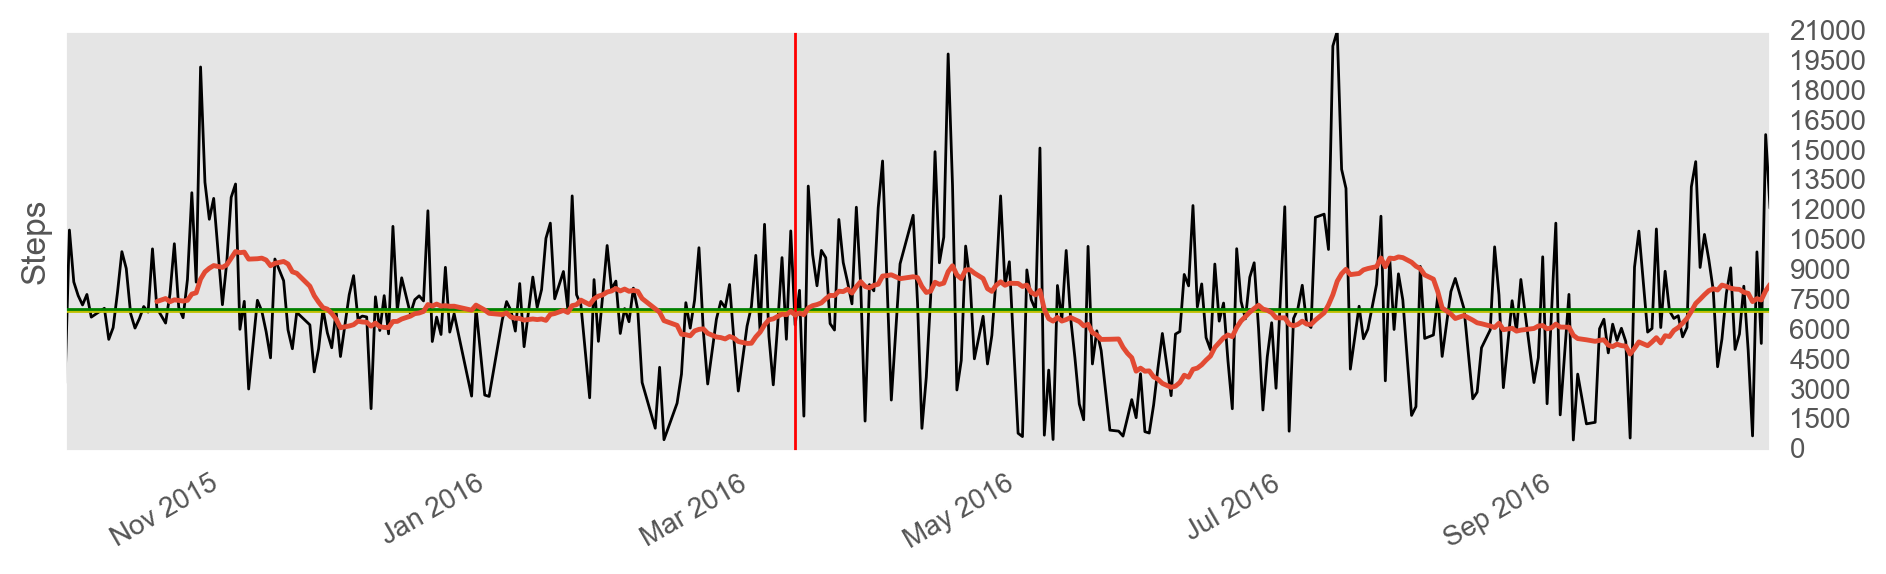

In [9]:
medianval = np.round(data_for_steps.ix[:,'Steps (count)'].median(),1)
avgval = np.round(data_for_steps.ix[:,'Steps (count)'].mean(),1)
maxval = np.round(data_for_steps.ix[:,'Steps (count)'].max(),1)

minor_ticks = np.arange(0, maxval+1, 1500, dtype=int)
minor_labels = minor_ticks

ax1 = data_for_steps.ix[:,'Steps (count)'].plot(color='000000',figsize=(11, 3),linewidth=1.0)

ax1.set_ylim(0,maxval)
ax1.set_ylabel('Steps')
ax1.set_yticks(minor_ticks)
ax1.set_yticklabels(minor_labels)
ax1.yaxis.tick_right()

ax1.set_xticks(data_for_steps.index, minor=True)
#Add the horizontal and vertical lines
ax1.axhline(y=medianval, linewidth=1, color='y')
ax1.axhline(y=avgval, linewidth=1, color='g')
ax1.axvline(x='2016-03-11', linewidth=1, color='r')
ax1.grid(b=False)

#Rolling 20 Day MA
ma = data_for_steps.ix[:,'Steps (count)'].rolling(20).mean()
ax1.plot(ma)

pd.DataFrame(data_for_steps["Steps (count)"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
Flights Climbed (count),341.0,11.49455,8.397825,0.0,5.0,10.882097,17.0,40.4134


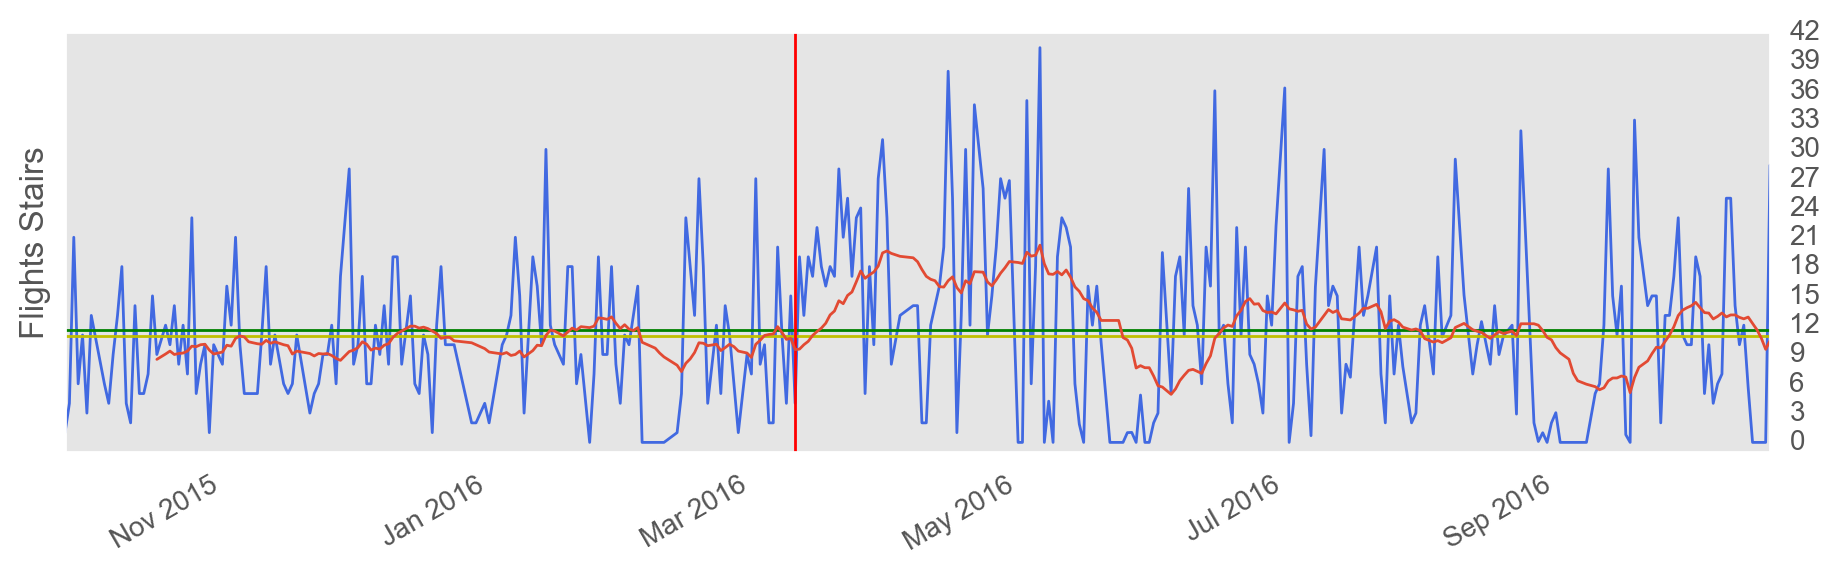

In [10]:
medianval2 = np.round(data_for_steps.ix[:,'Flights Climbed (count)'].median(),1)
avgval2 = np.round(data_for_steps.ix[:,'Flights Climbed (count)'].mean(),1)
maxval2 = np.round(data_for_steps.ix[:,'Flights Climbed (count)'].max(),1)

minor_ticks_stairs = np.arange(0, maxval2+2, 3, dtype=int)
minor_labels_stairs = minor_ticks_stairs

ax2 = data_for_steps.ix[:,'Flights Climbed (count)'].plot(color='royalblue',figsize=(11, 3),linewidth=1.0)

ax2.set_ylim(-1,maxval2)
ax2.set_ylabel('Flights Stairs')
ax2.set_yticks(minor_ticks_stairs)
ax2.set_yticklabels(minor_labels_stairs)
ax2.yaxis.tick_right()

#Add the horizontal and vertical lines
ax2.axhline(y=medianval2, linewidth=1, color='y')
ax2.axhline(y=avgval2, linewidth=1, color='g')
ax2.axvline(x='2016-03-11', linewidth=1, color='r')
ax2.grid(b=False)

#Rolling 20 Day MA
ma2 = data_for_steps.ix[:,'Flights Climbed (count)'].rolling(20).mean()
ax2.plot(ma2,linewidth=1.0)

pd.DataFrame(data_for_steps['Flights Climbed (count)'].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
Distance (km),341.0,5.682842,2.721183,0.45,4.396161,5.53,7.0,17.8


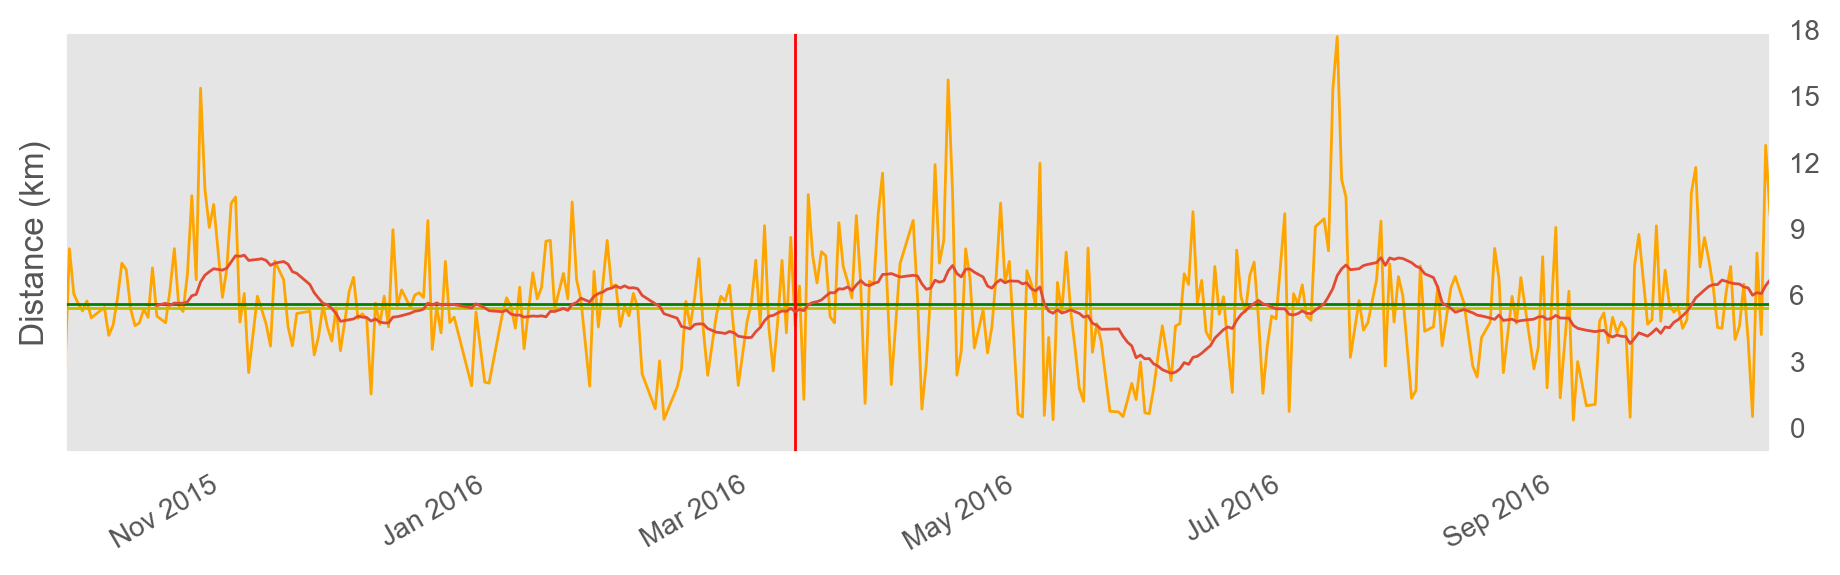

In [11]:
medianval3 = np.round(data_for_steps.ix[:,'Distance (km)'].median(),1)
avgval3 = np.round(data_for_steps.ix[:,'Distance (km)'].mean(),1)
maxval3 = np.round(data_for_steps.ix[:,'Distance (km)'].max(),1)

minor_ticks_km = np.arange(0, maxval3+1, 3, dtype=int)
minor_labels_km = minor_ticks_km

ax6 = data_for_steps.ix[:,'Distance (km)'].plot(color='orange',figsize=(11, 3),linewidth=1.0)

ax6.set_ylim(-1,data_for_steps.ix[:,'Distance (km)'].max())
ax6.set_ylabel('Distance (km)')
ax6.set_yticks(minor_ticks_km)
ax6.set_yticklabels(minor_labels_km)
ax6.yaxis.tick_right()

#Add the horizontal and vertical lines
ax6.axhline(y=medianval3, linewidth=1, color='y')
ax6.axhline(y=avgval3, linewidth=1, color='g')
ax6.axvline(x='2016-03-11', linewidth=1, color='r')
ax6.grid(b=False)

#Rolling 20 Day MA
ma2 = data_for_steps.ix[:,'Distance (km)'].rolling(20).mean()
ax6.plot(ma2,linewidth=1.0)

pd.DataFrame(data_for_steps['Distance (km)'].describe()).transpose()

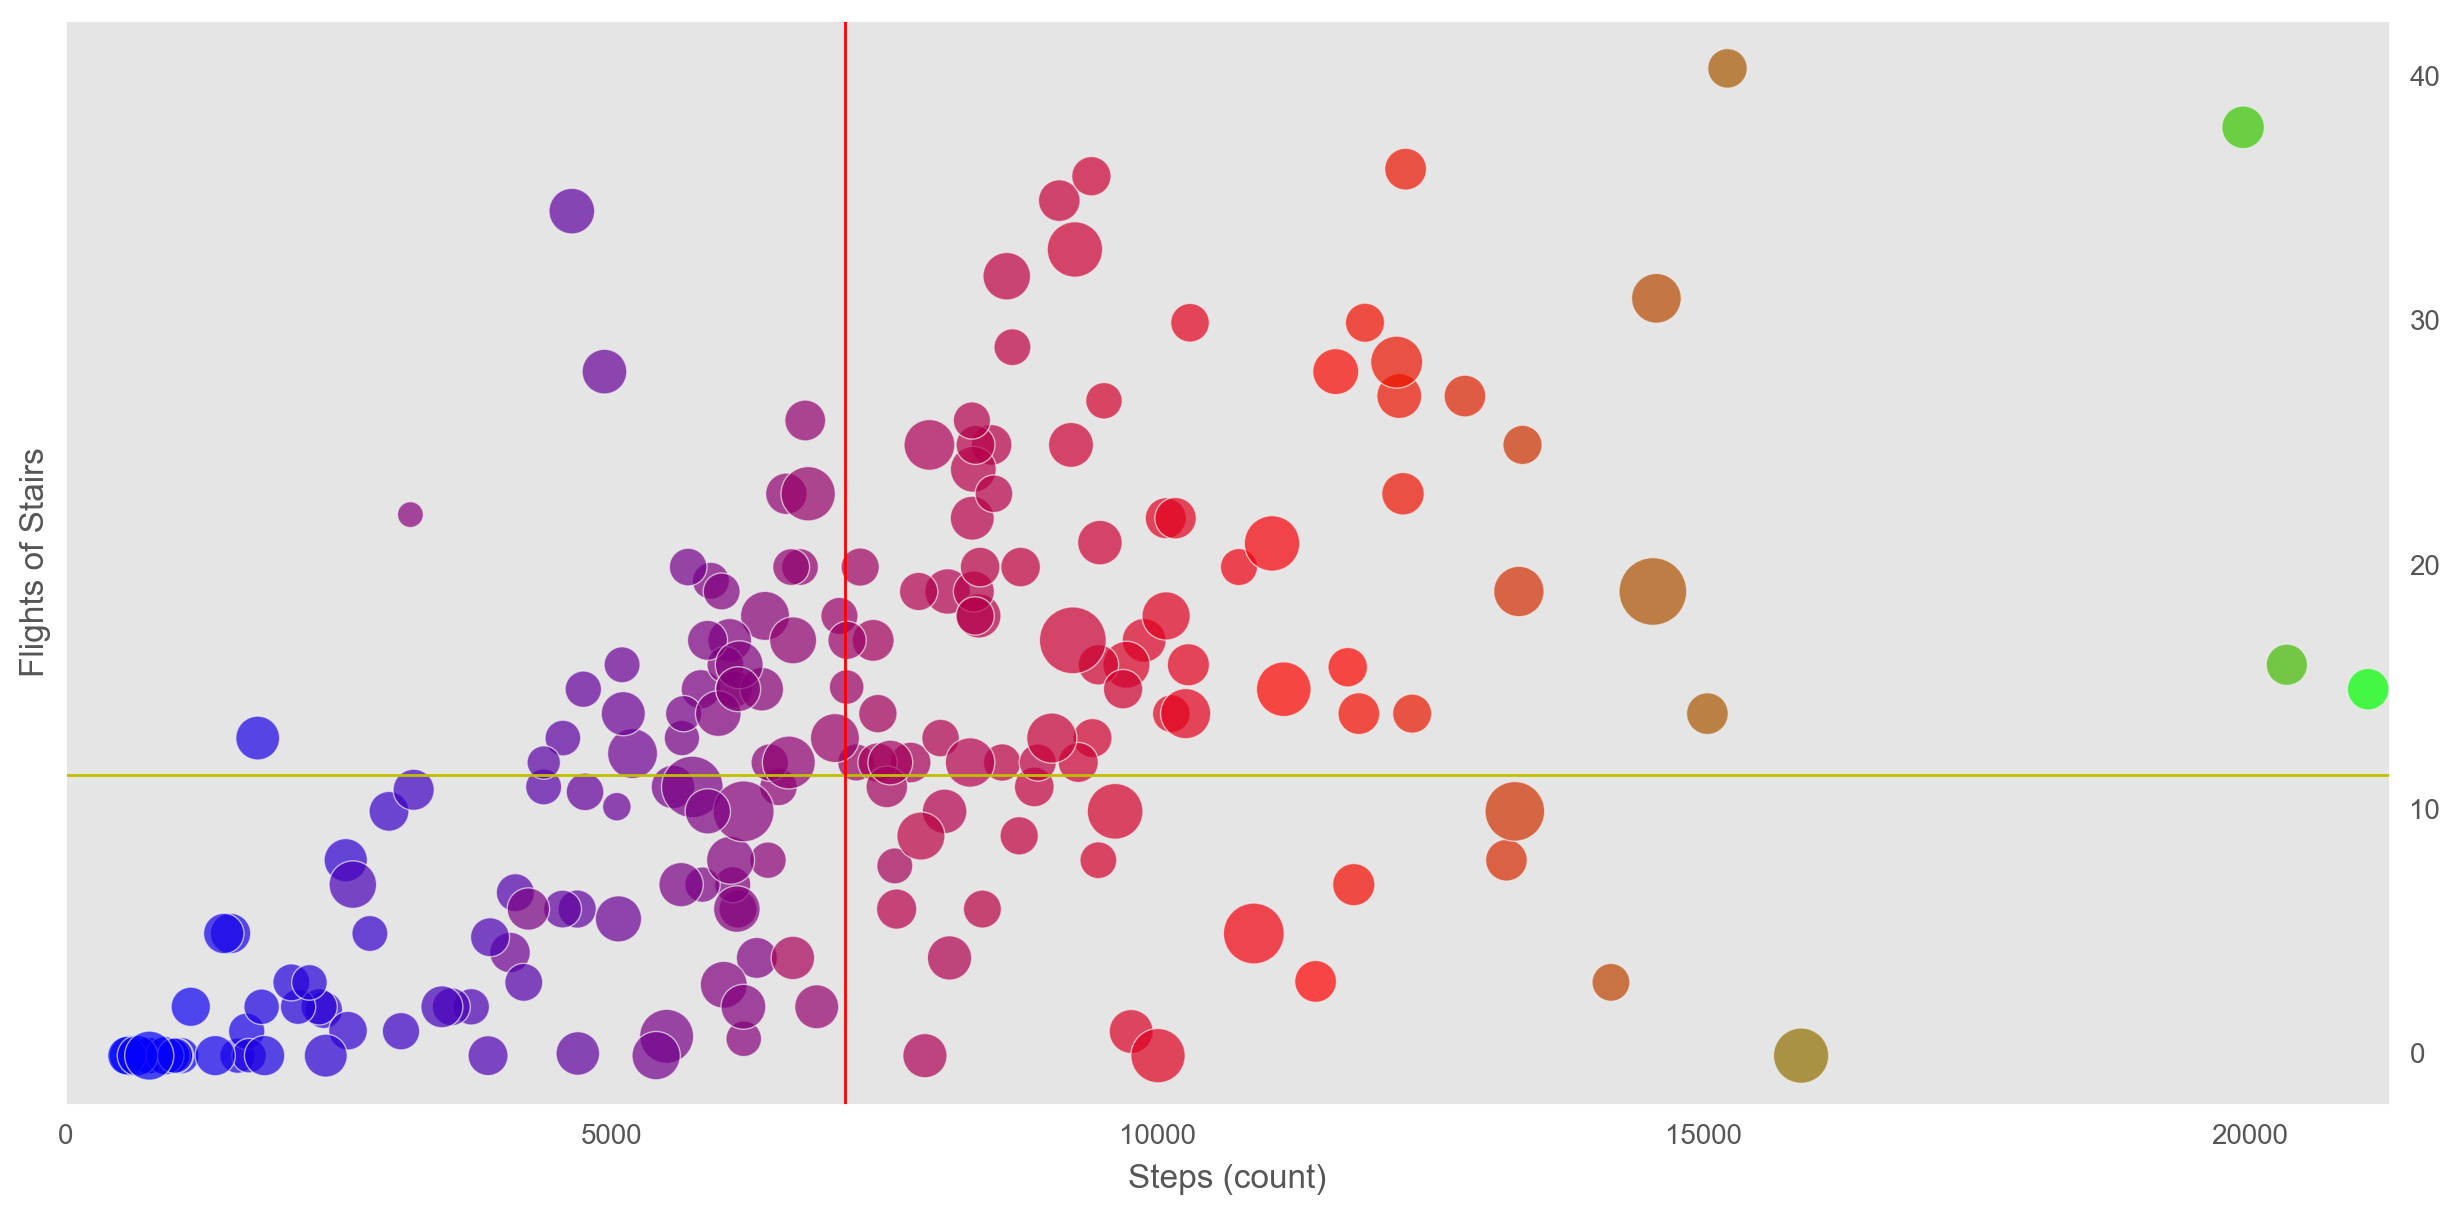

In [12]:
#Scatter chart Steps vs Stairs
plt.figure(1,figsize=(15,7))

x = data_for_steps.ix[:,'Steps (count)']
y = data_for_steps.ix[:,'Flights Climbed (count)']
plt.xlabel('Steps (count)')
plt.ylabel('Flights of Stairs')
plt.xlim(-5,data_for_steps.ix[:,'Steps (count)'].max()+200)
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
plt.ylim(-2,data_for_steps.ix[:,'Flights Climbed (count)'].max()+2)
plt.grid(b=False)
plt.axhline(y=avgval2, linewidth=1, color='y')
plt.axvline(x=avgval, linewidth=1, color='r')

plt.scatter(x, y, alpha=0.7,c=data_for_steps.ix[:,'Distance (km)'], s=data_for_steps.ix[:,'Total Calories (kcal)']/10, cmap=cm.brg)
plt.show()

##### Most active day ever by number of climbed stairs

In [13]:
data_for_steps.ix[data_for_steps['Flights Climbed (count)']==data_for_steps['Flights Climbed (count)'].max()]

,Active Calories (kcal),Body Fat Percentage (%),Body Mass Index (count),Distance (km),Flights Climbed (count),Heart Rate (count/min),Lean Body Mass (kg),Resting Calories (kcal),Steps (count),Weight (kg),Total Calories (kcal),Weekday
2016-05-06,513.0,12.3,18.0,12.07,40.4134,115.0,48.91029,1526.0,15216.0,55.77,2039.0,4 Fri


##### Most active day ever by number of steps

In [14]:
data_for_steps.ix[data_for_steps['Steps (count)']==data_for_steps['Steps (count)'].max()]

,Active Calories (kcal),Body Fat Percentage (%),Body Mass Index (count),Distance (km),Flights Climbed (count),Heart Rate (count/min),Lean Body Mass (kg),Resting Calories (kcal),Steps (count),Weight (kg),Total Calories (kcal),Weekday
2016-07-13,724.0,10.3,17.8,17.8,15.0,128.0,49.37088,1525.0,21082.0,55.04,2249.0,2 Weds


##### Most active day ever by distance done

In [15]:
data_for_steps.ix[data_for_steps['Distance (km)']==data_for_steps['Distance (km)'].max()]

,Active Calories (kcal),Body Fat Percentage (%),Body Mass Index (count),Distance (km),Flights Climbed (count),Heart Rate (count/min),Lean Body Mass (kg),Resting Calories (kcal),Steps (count),Weight (kg),Total Calories (kcal),Weekday
2016-07-13,724.0,10.3,17.8,17.8,15.0,128.0,49.37088,1525.0,21082.0,55.04,2249.0,2 Weds


#### Weight, Lean Body Mass and Body Fat % Analysis

,Weight (kg),Lean Body Mass (kg),Body Fat Percentage (%),Body Mass Index (count)
2016-10-21,54.459999,47.761419,12.3,17.6


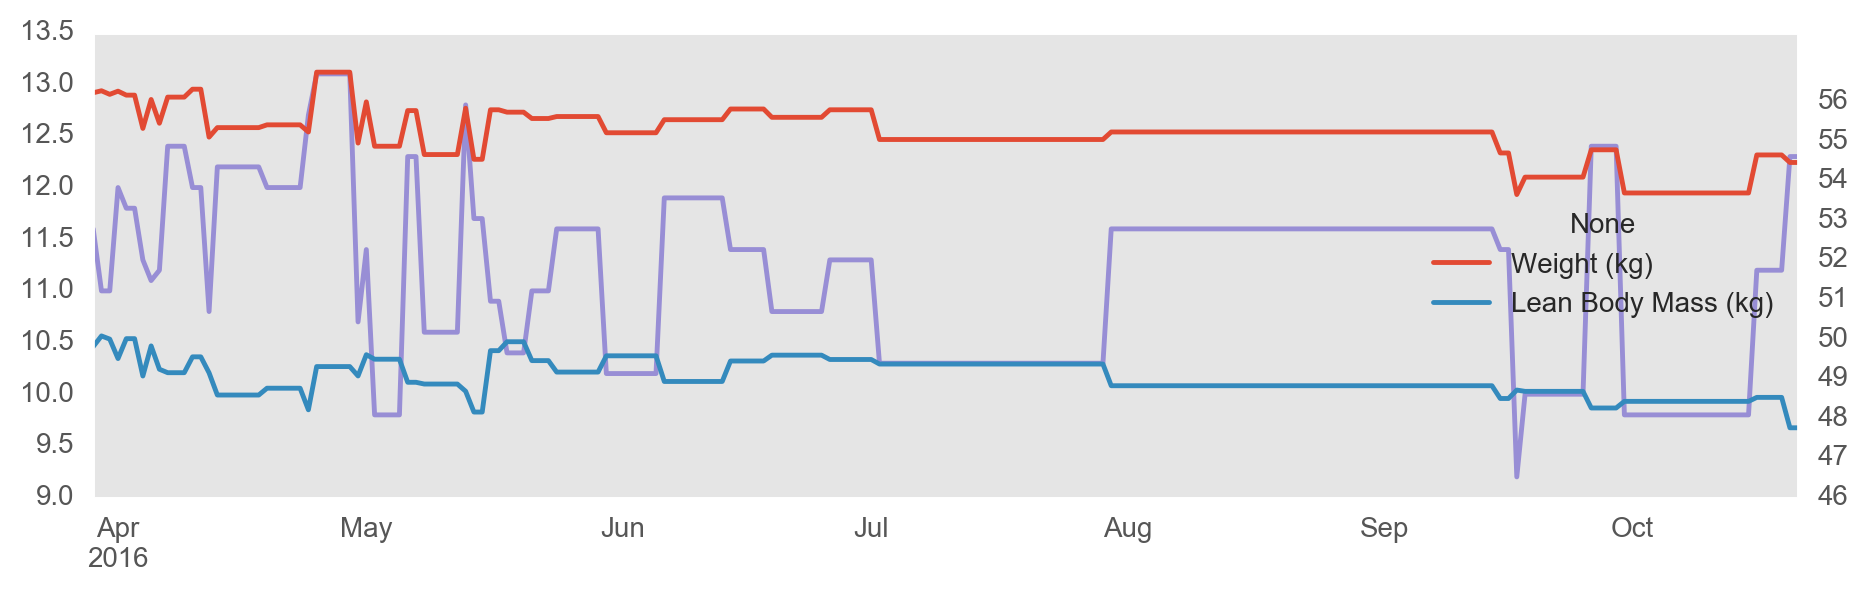

In [16]:
minor_ticks_weight = np.arange(data_for_weight['Lean Body Mass (kg)'].min()-1, data_for_weight['Weight (kg)'].max()+1, 1, dtype=int)
minor_labels_weight = minor_ticks_weight

ax9 = data_for_weight['Weight (kg)'].plot(secondary_y=True,figsize=(11, 3));
ax9 = data_for_weight['Lean Body Mass (kg)'].plot(secondary_y=True,figsize=(11, 3));
ax9.legend(loc=1, bbox_to_anchor=(0.5, 0.1), ncol=2)
ax9.grid(b=False)
ax9.yaxis.tick_right()
ax9.set_ylim(data_for_weight['Lean Body Mass (kg)'].min()-1,data_for_weight['Weight (kg)'].max()+1)
ax9.set_yticks(minor_ticks_weight)
ax9.set_yticklabels(minor_labels_weight)
ax4 = data_for_weight['Body Fat Percentage (%)'].plot(figsize=(11, 3))
ax4.yaxis.tick_left()
ax4.grid(b=False)

data_for_weight.tail(1)

In [17]:
#Averages, Medians, High, Low per Weekday
data_for_weekday.groupby('Weekday').agg(['mean','median','min','max','std']).transpose()

Weekday                                0 Mon         1 Tue        2 Weds  \
Active Calories (kcal)  mean      802.343750    686.937500    608.031250   
                        median    555.500000    597.500000    555.000000   
                        min        40.000000      0.000000      0.000000   
                        max      4100.000000   3946.000000   2946.000000   
                        std       835.491534    728.033717    595.964682   
Distance (km)           mean        5.564019      6.146152      6.380868   
                        median      5.690000      5.935501      5.708204   
                        min         0.450000      0.740000      0.484112   
                        max        11.880000     15.466486     17.800000   
                        std         2.392003      2.720320      2.877234   
Flights Climbed (count) mean       12.345636     12.247661     13.215248   
                        median     12.683235     11.500000     12.000000   
                        min         0.000000      0.000000      0.000000   
                        max        33.000000     35.000000     36.000000   
                        std         8.088919      8.268011      8.977232   
Heart Rate (count/min)  mean       72.392857     68.535714     68.267857   
                        median    102.000000     99.000000    102.500000   
                        min         0.000000      0.000000      0.000000   
                        max       175.000000    161.000000    172.000000   
                        std        65.259393     63.862057     63.340778   
Resting Calories (kcal) mean     1660.281250   1660.281250   1629.375000   
                        median   1532.000000   1532.000000   1531.000000   
                        min      1520.000000   1520.000000    790.000000   
                        max      1860.000000   1860.000000   1860.000000   
                        std       162.921361    162.921361    231.331734   
Steps (count)           mean     7008.909091   7775.054545   8033.735849   
                        median   7172.000000   7507.000000   7339.000000   
                        min       562.000000    910.000000    575.000000   
                        max     14533.000000  20337.000000  21082.000000   
                        std      2966.793838   3417.138528   3553.486934   
Total Calories (kcal)   mean     2462.625000   2347.218750   2237.406250   
                        median   2083.500000   2201.000000   2109.500000   
                        min      1566.000000   1636.000000    872.000000   
                        max      5960.000000   5806.000000   4806.000000   
                        std       950.180620    814.771479    726.525663   

Weekday                              3 Thurs         4 Fri         5 Sat  \
Active Calories (kcal)  mean      621.312500    545.937500    592.156250   
                        median    377.000000    441.000000    367.000000   
                        min         0.000000      0.000000      0.000000   
                        max      2177.000000   3059.000000   2957.000000   
                        std       585.496670    583.820340    666.218656   
Distance (km)           mean        6.237666      6.641287      4.222729   
                        median      5.838327      6.471551      3.790000   
                        min         1.100000      1.460000      0.660000   
                        max        11.625000     15.840000     10.810000   
                        std         2.288325      2.680271      2.375915   
Flights Climbed (count) mean       12.116842     11.456988      6.084655   
                        median     11.000000     11.000000      4.500000   
                        min         0.000000      0.000000      0.000000   
                        max        34.569647     40.413400     26.000000   
                        std         9.008967      9.661268      6.611552   
Heart Rate (count/min)  mean       63.196429   

#### Heart Rate Data Analysis

[]

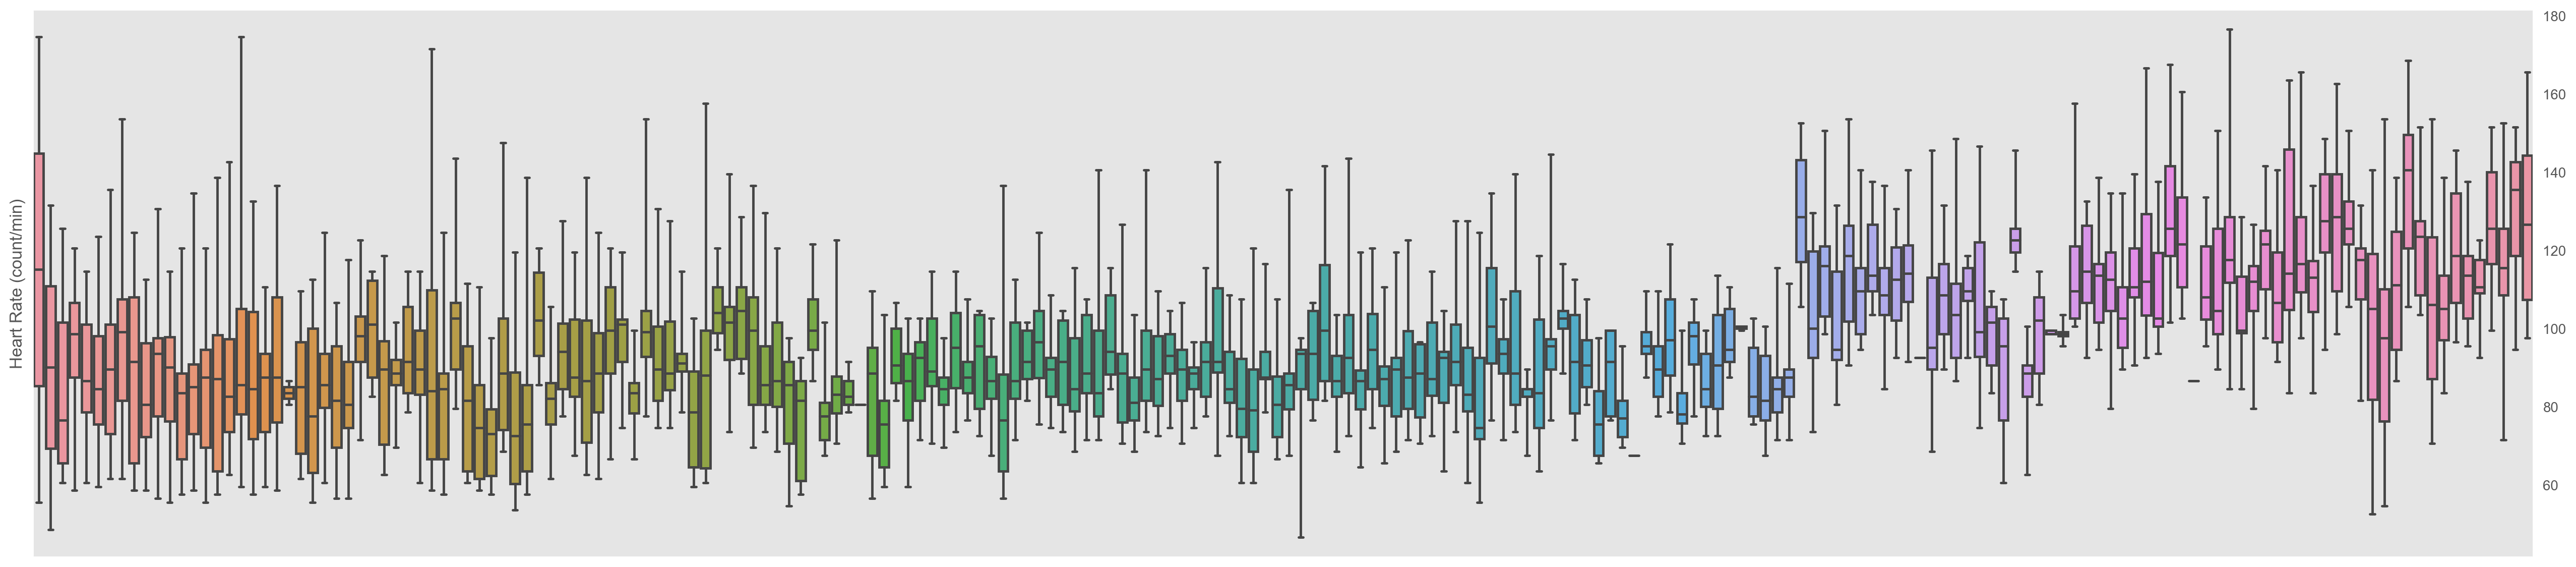

In [18]:
#Box Plot for Heart Rate Data 
plt.figure(figsize=(32,7))
ax5 = sns.boxplot(x="Date", y="Heart Rate (count/min)", data=hr_intraday, whis=[0,100])
ax5.set_ylim(hr_intraday['Heart Rate (count/min)'].min()-5,hr_intraday['Heart Rate (count/min)'].max()+5)
ax5.set_xticklabels(hr_intraday['Date'].unique())
ax5.grid(b=False)
ax5.yaxis.tick_right()
ax5.axes.get_xaxis().set_visible(False)
labels = ax5.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=8)
ax5.plot()

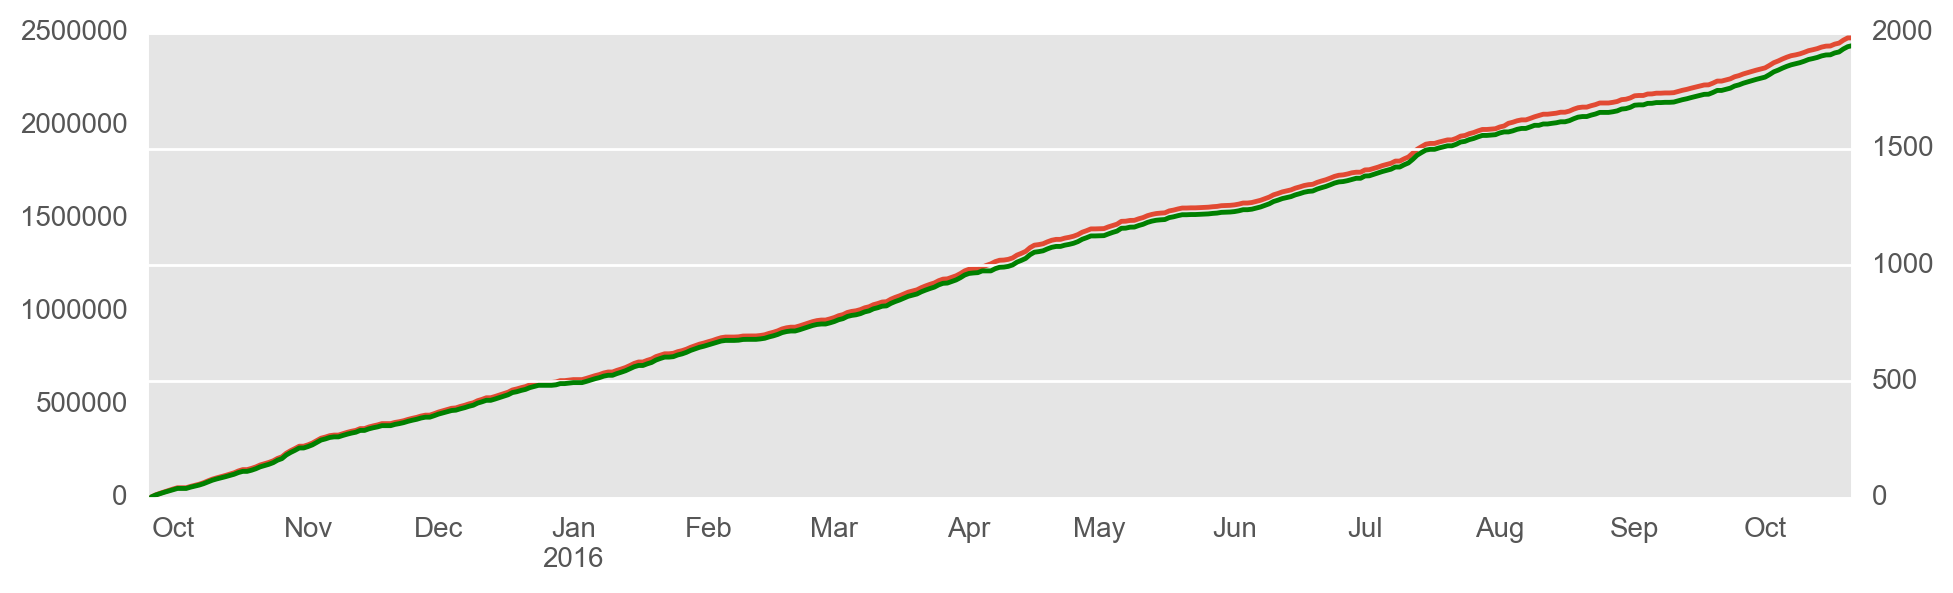

In [19]:
#Cumulative Charts
#Cumulative steps done
#Cumulative km walked
#Cumulative dataset

cumulative = data[['Steps (count)','Distance (km)','Flights Climbed (count)']].copy()
cumulative = cumulative.cumsum(axis=0, skipna=True)
cumulative = cumulative.fillna(method='ffill')
cumulative['Steps (count)'].plot(figsize=(11,3))
cumulative['Distance (km)'].plot(secondary_y=True, style='g')

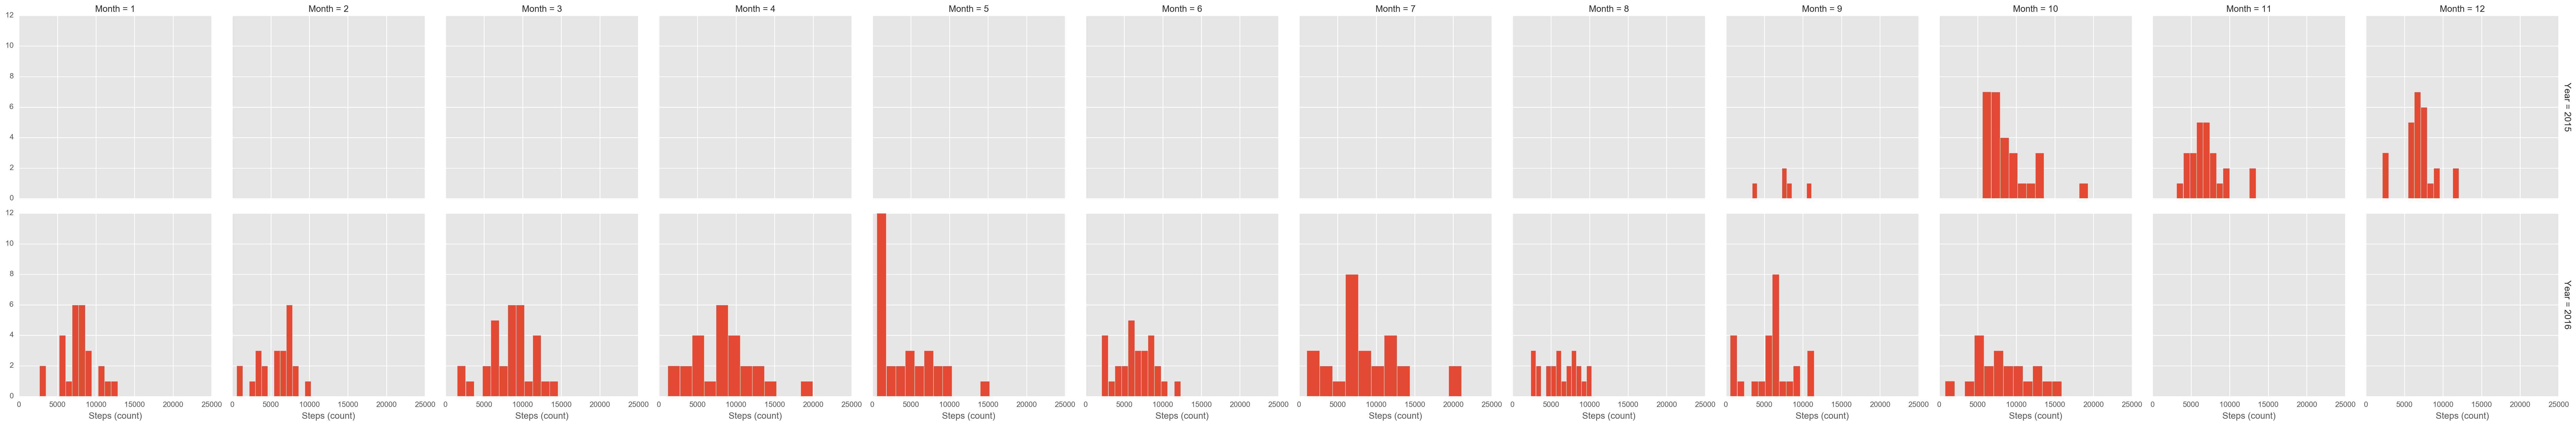

In [20]:
#matrix charts histograms steps done per month
matrixdata = data_for_steps[['Steps (count)','Distance (km)','Flights Climbed (count)','Weekday']].copy()
matrixdata['Month']=pd.to_datetime(matrixdata.index).month
matrixdata['Year']=pd.to_datetime(matrixdata.index).year
g = sns.FacetGrid(matrixdata, row="Year", col="Month", size=4, margin_titles=True)
g.map(plt.hist, "Steps (count)", bins=12)

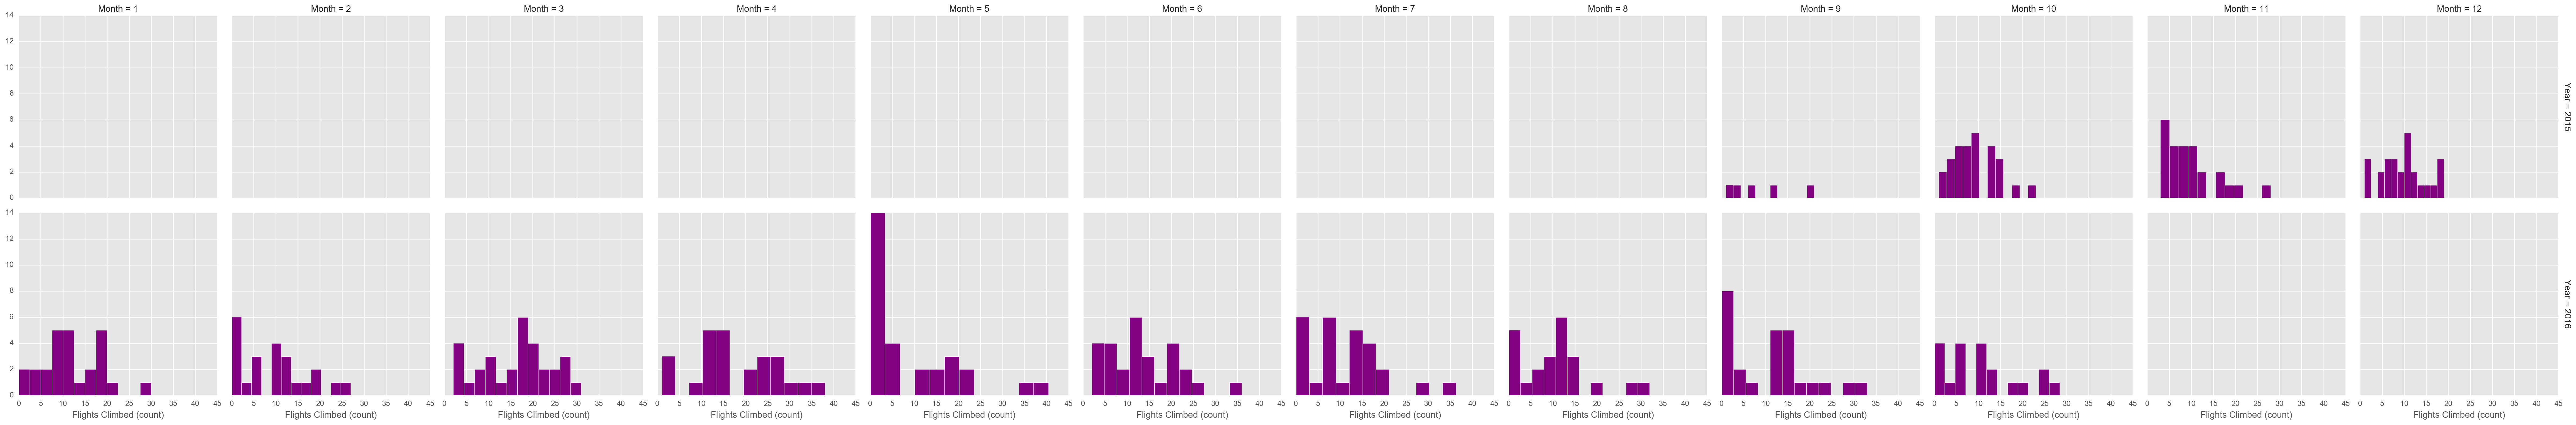

In [21]:
g = sns.FacetGrid(matrixdata, row="Year", col="Month", size=4, margin_titles=True)
g.map(plt.hist, "Flights Climbed (count)", bins=12, color="purple")

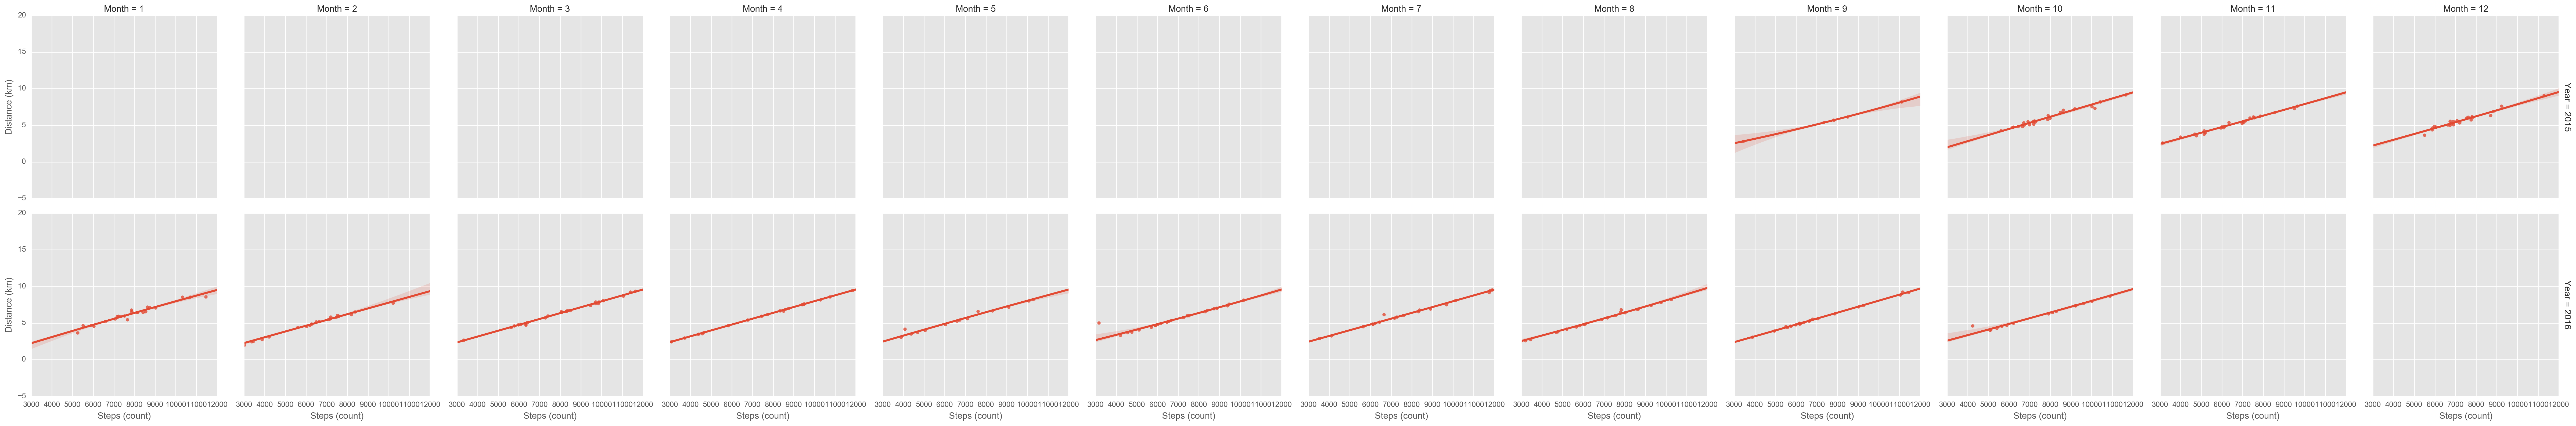

In [22]:
g = sns.FacetGrid(matrixdata, row="Year", col="Month", size=4, margin_titles=True)
g.map(sns.regplot, "Steps (count)", "Distance (km)", order=2)

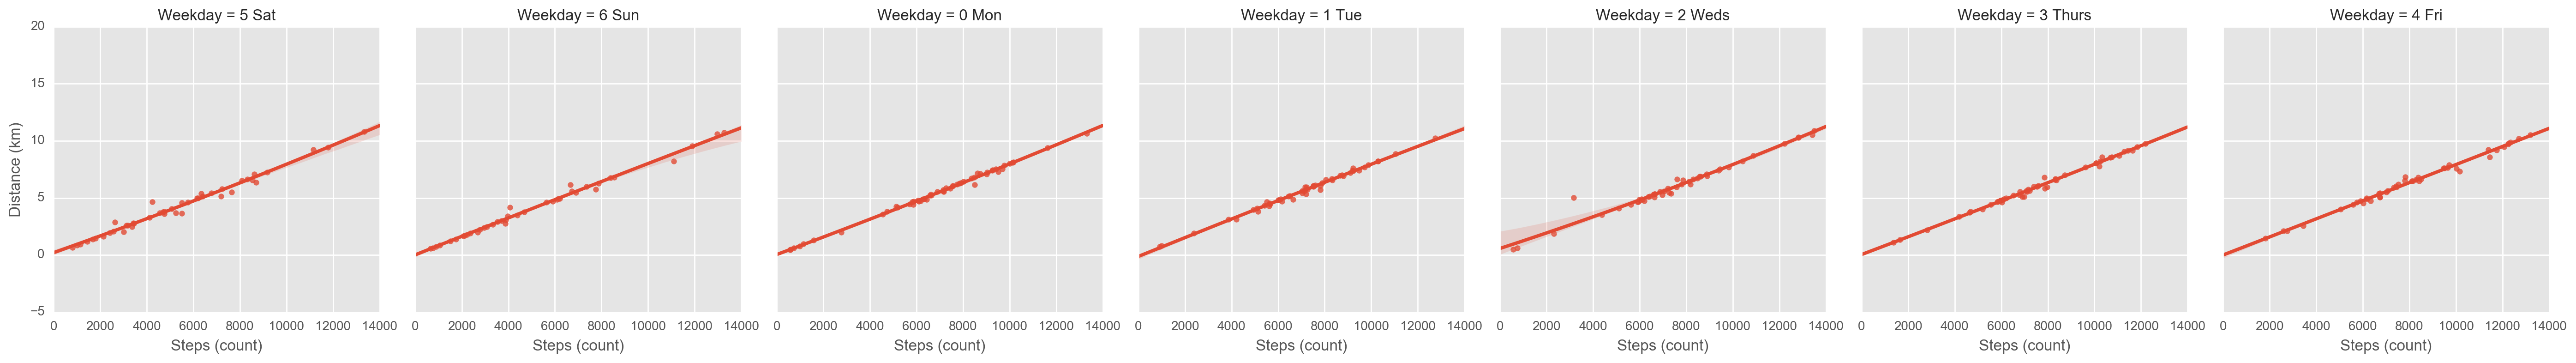

In [23]:
g = sns.FacetGrid(matrixdata, col="Weekday", size=4, margin_titles=True)
g.map(sns.regplot, "Steps (count)", "Distance (km)", order=2)

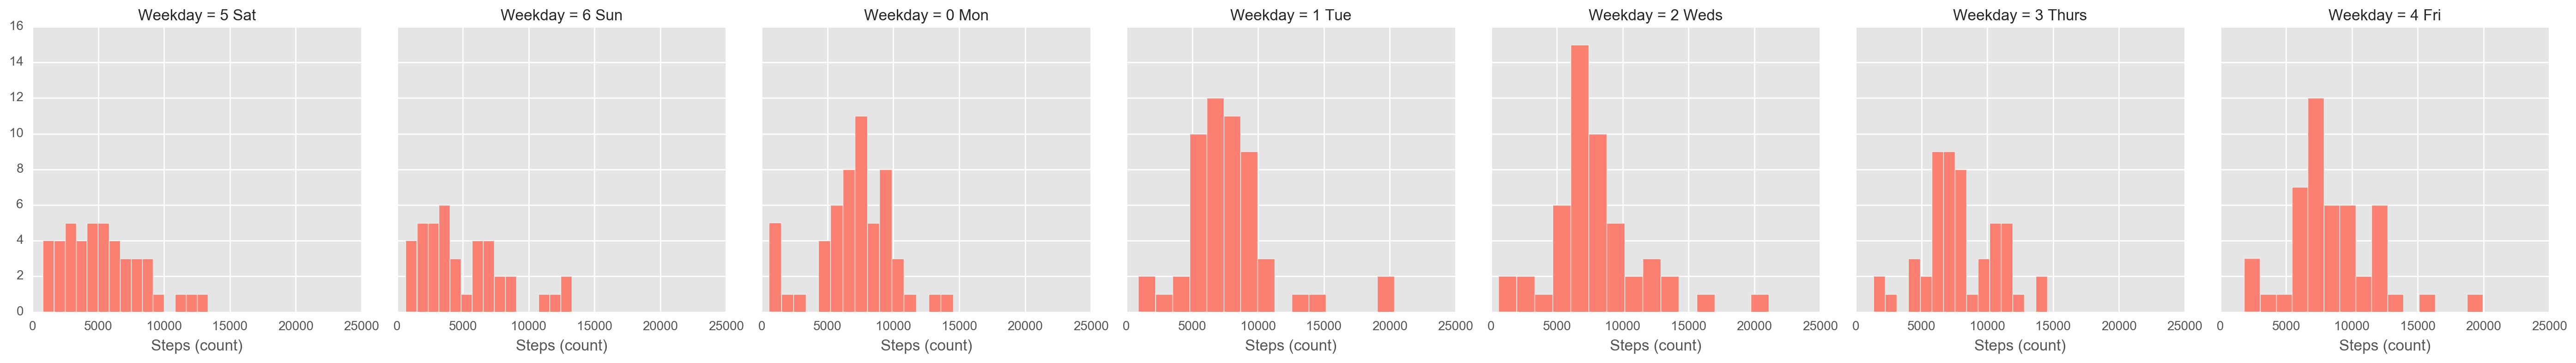

In [24]:
g = sns.FacetGrid(matrixdata, col="Weekday", size=4, margin_titles=True)
g.map(plt.hist, "Steps (count)", bins=15, color="salmon")

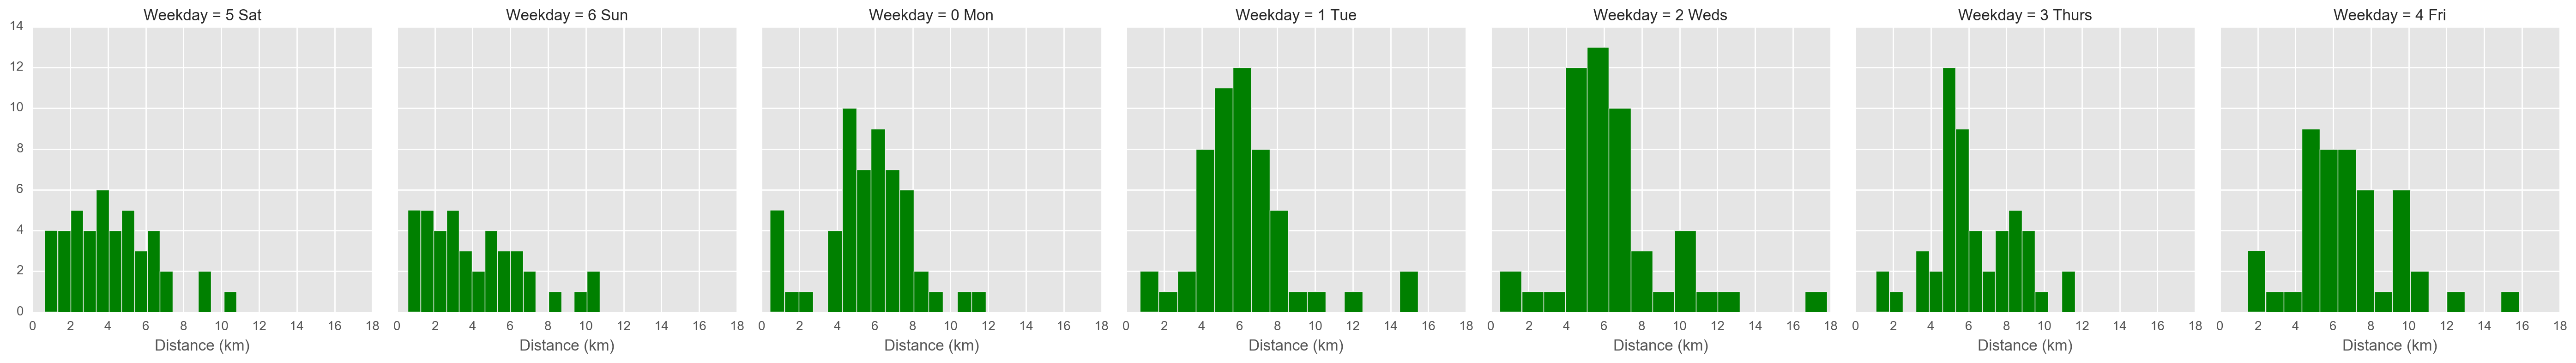

In [25]:
g = sns.FacetGrid(matrixdata, col="Weekday", size=4, margin_titles=True)
g.map(plt.hist, "Distance (km)", bins=15, color="g")

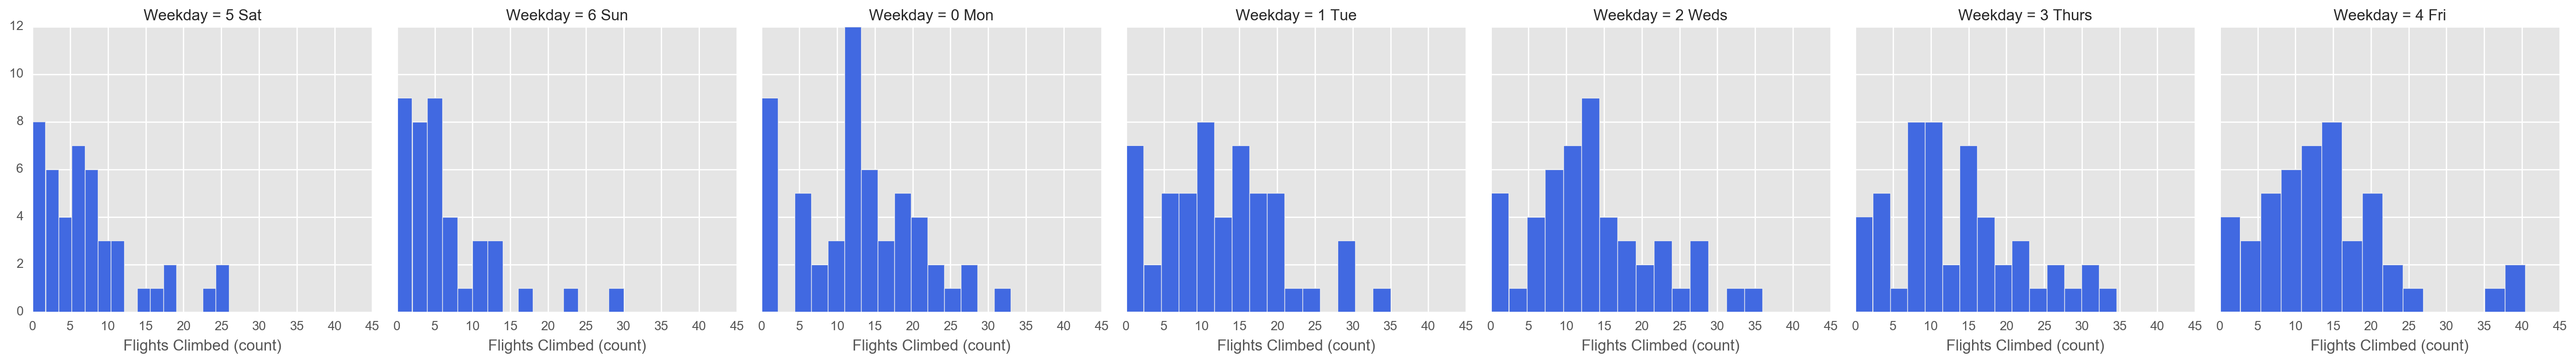

In [26]:
g = sns.FacetGrid(matrixdata, col="Weekday", size=4, margin_titles=True)
g.map(plt.hist, "Flights Climbed (count)", bins=15, color="royalblue")

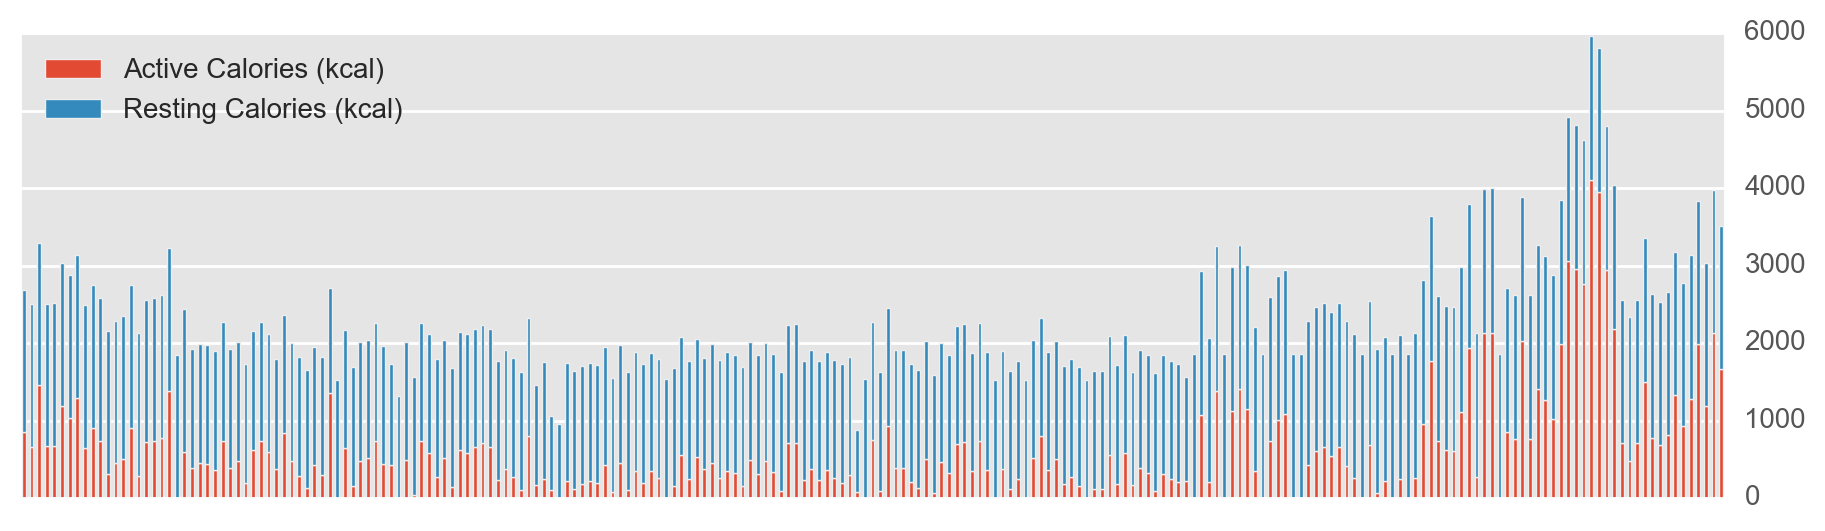

In [27]:
ax7 = data_for_cal2.plot.bar(stacked=True, figsize=(11, 3))
ax7.axes.get_xaxis().set_visible(False)
ax7.yaxis.tick_right()

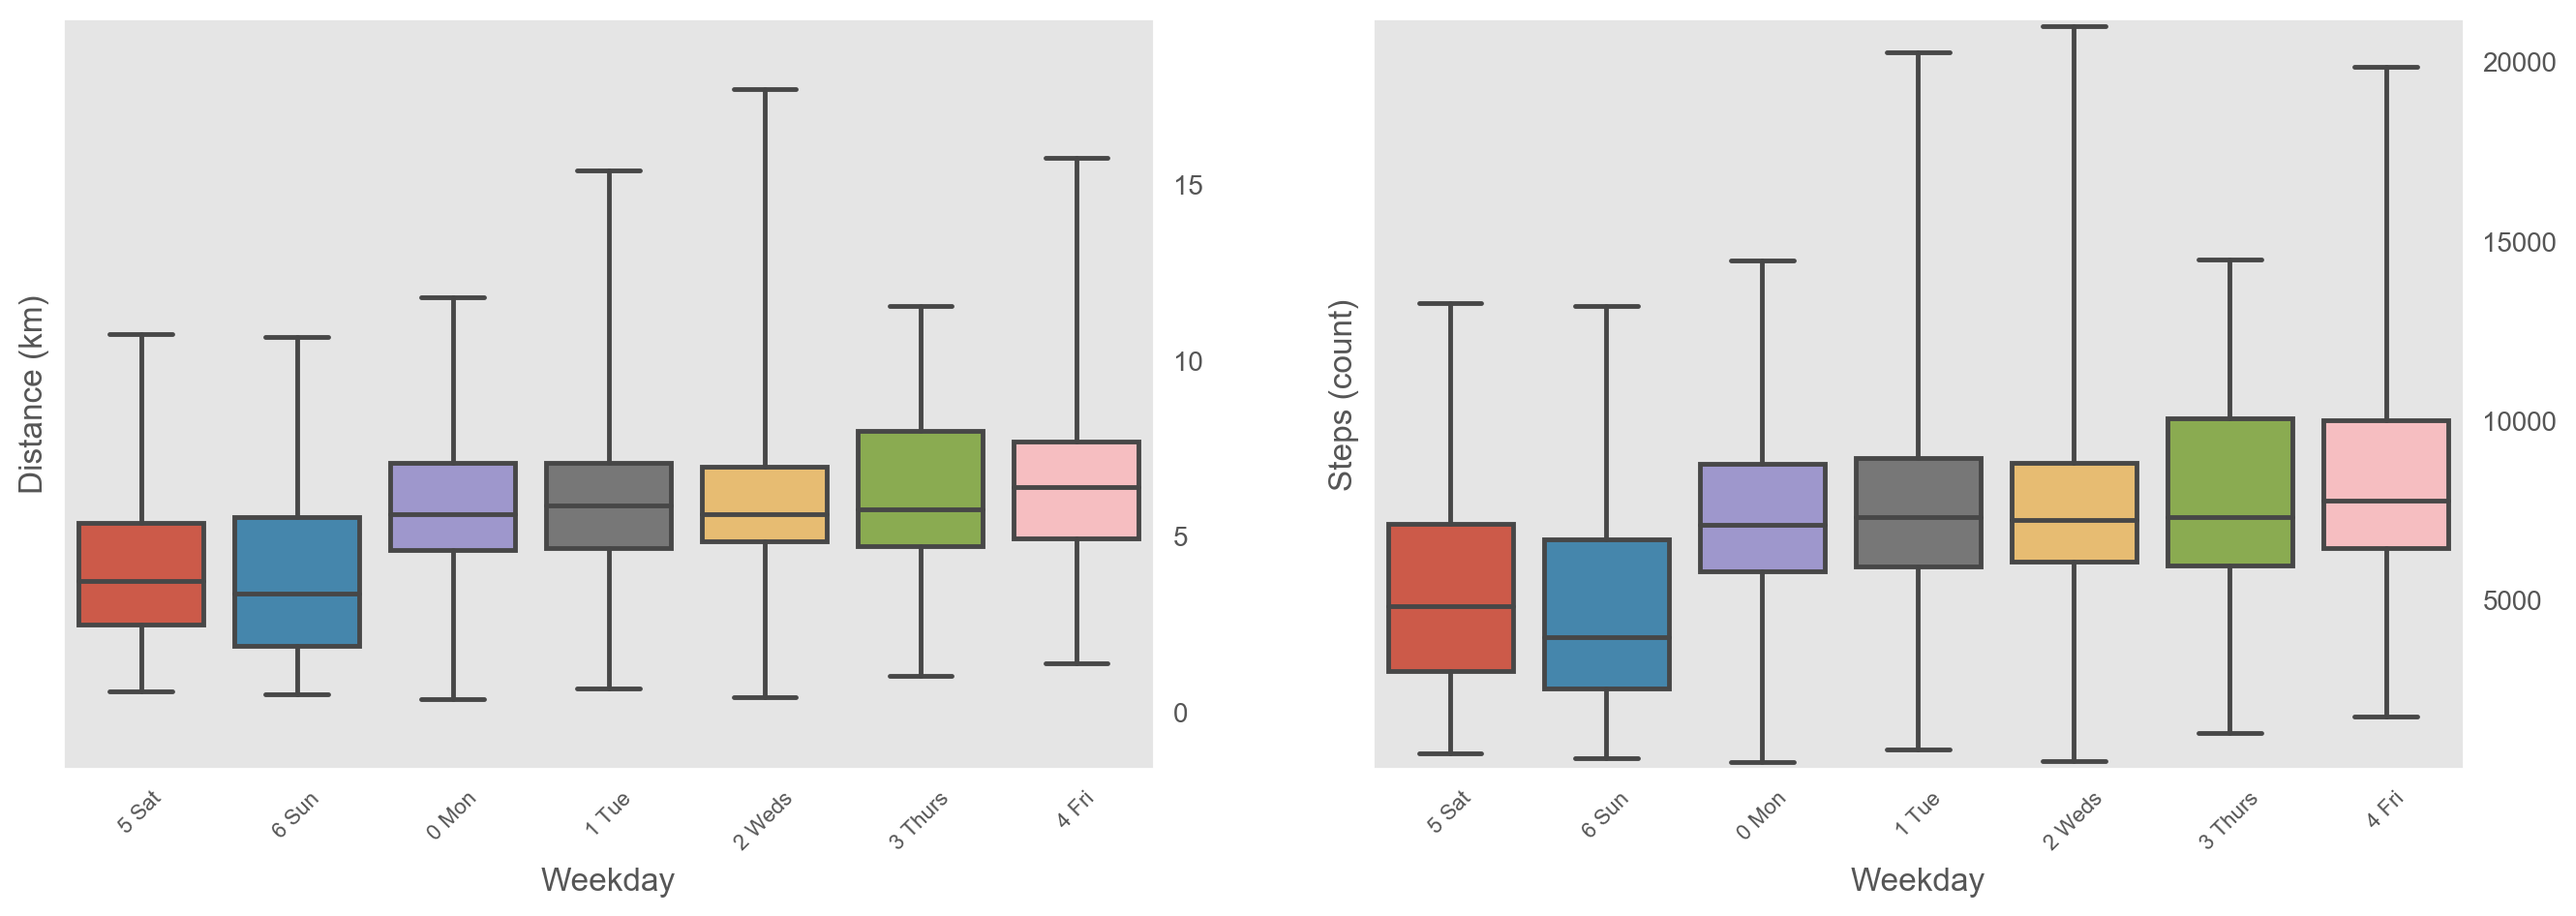

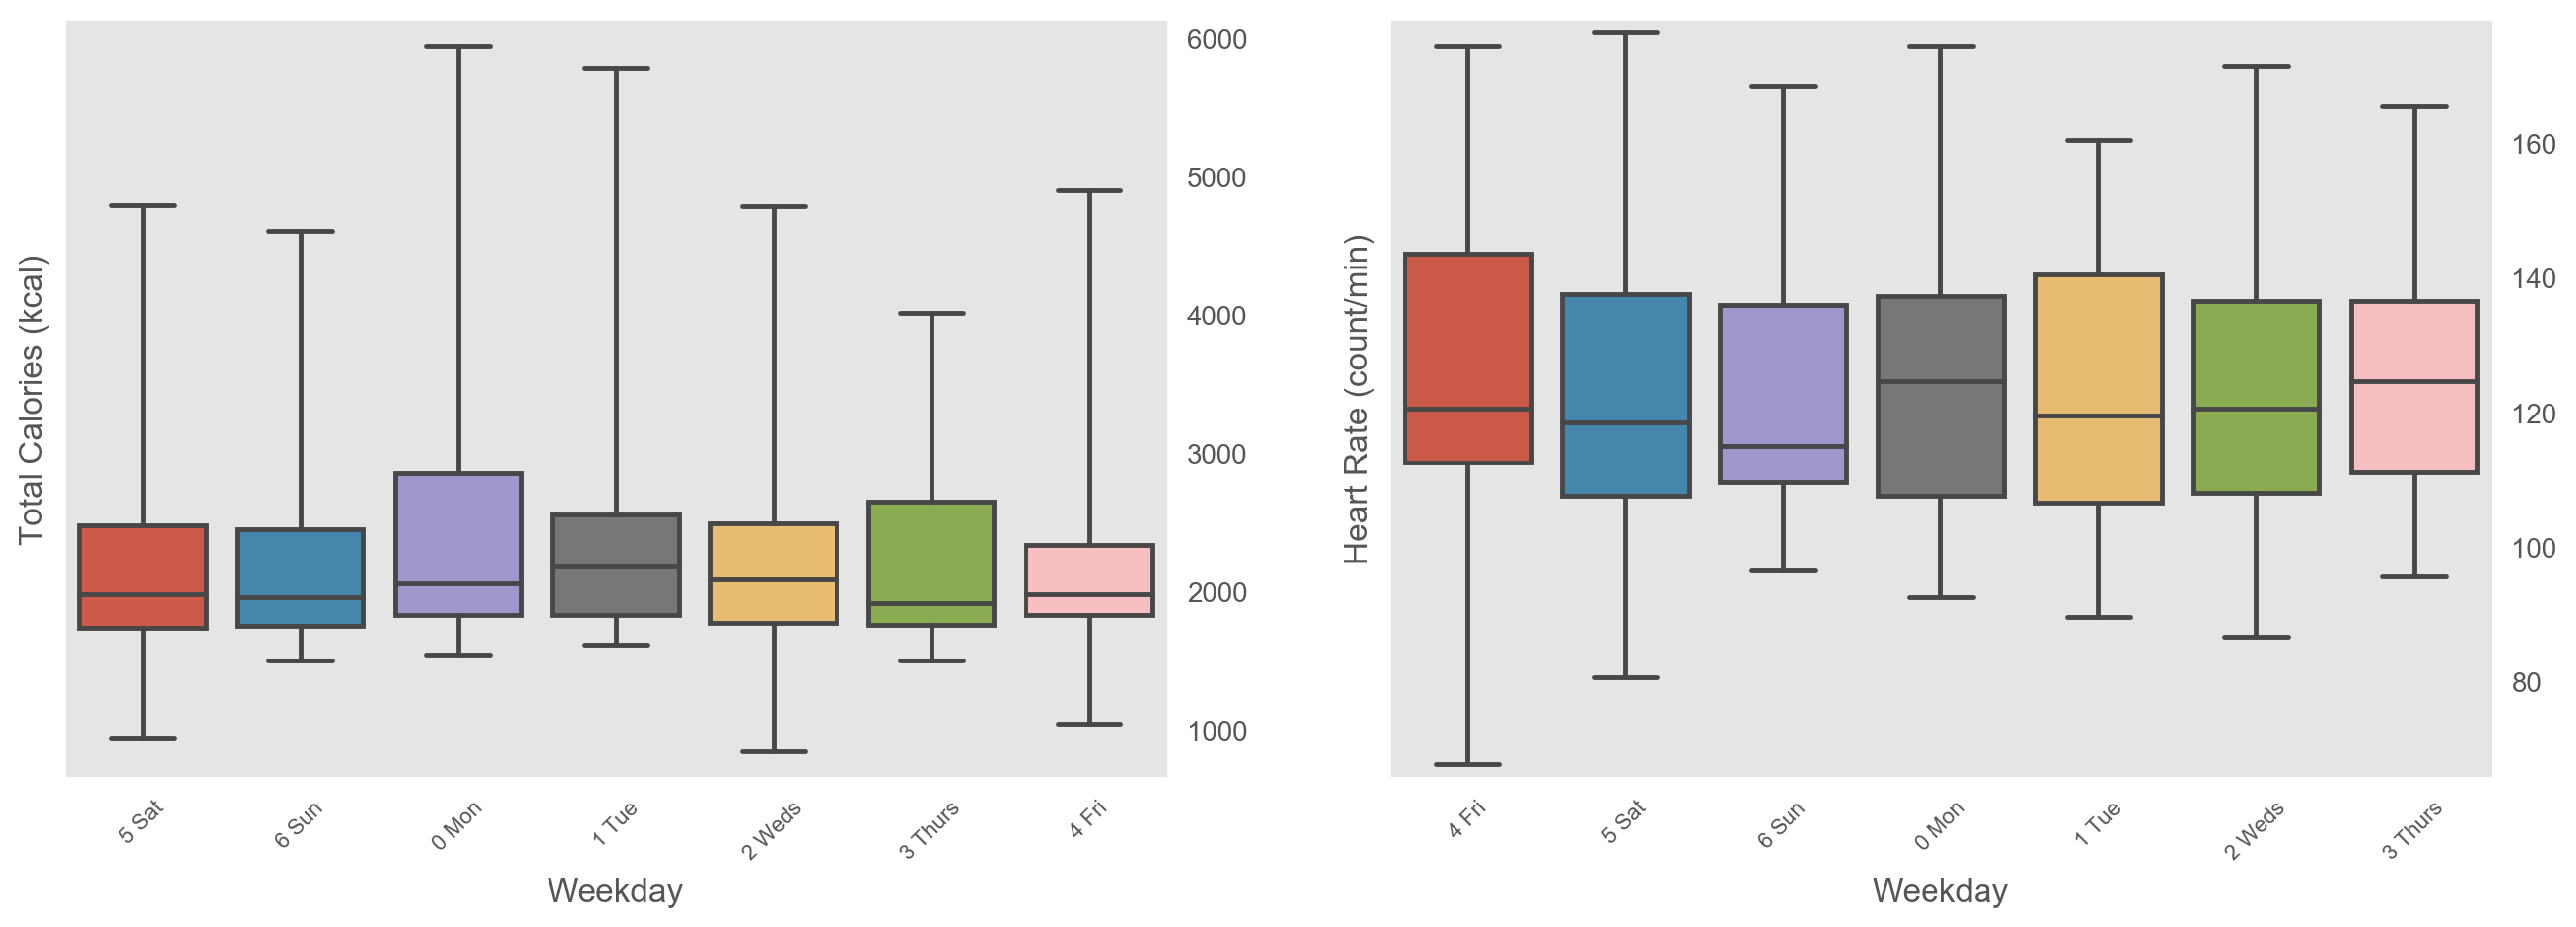

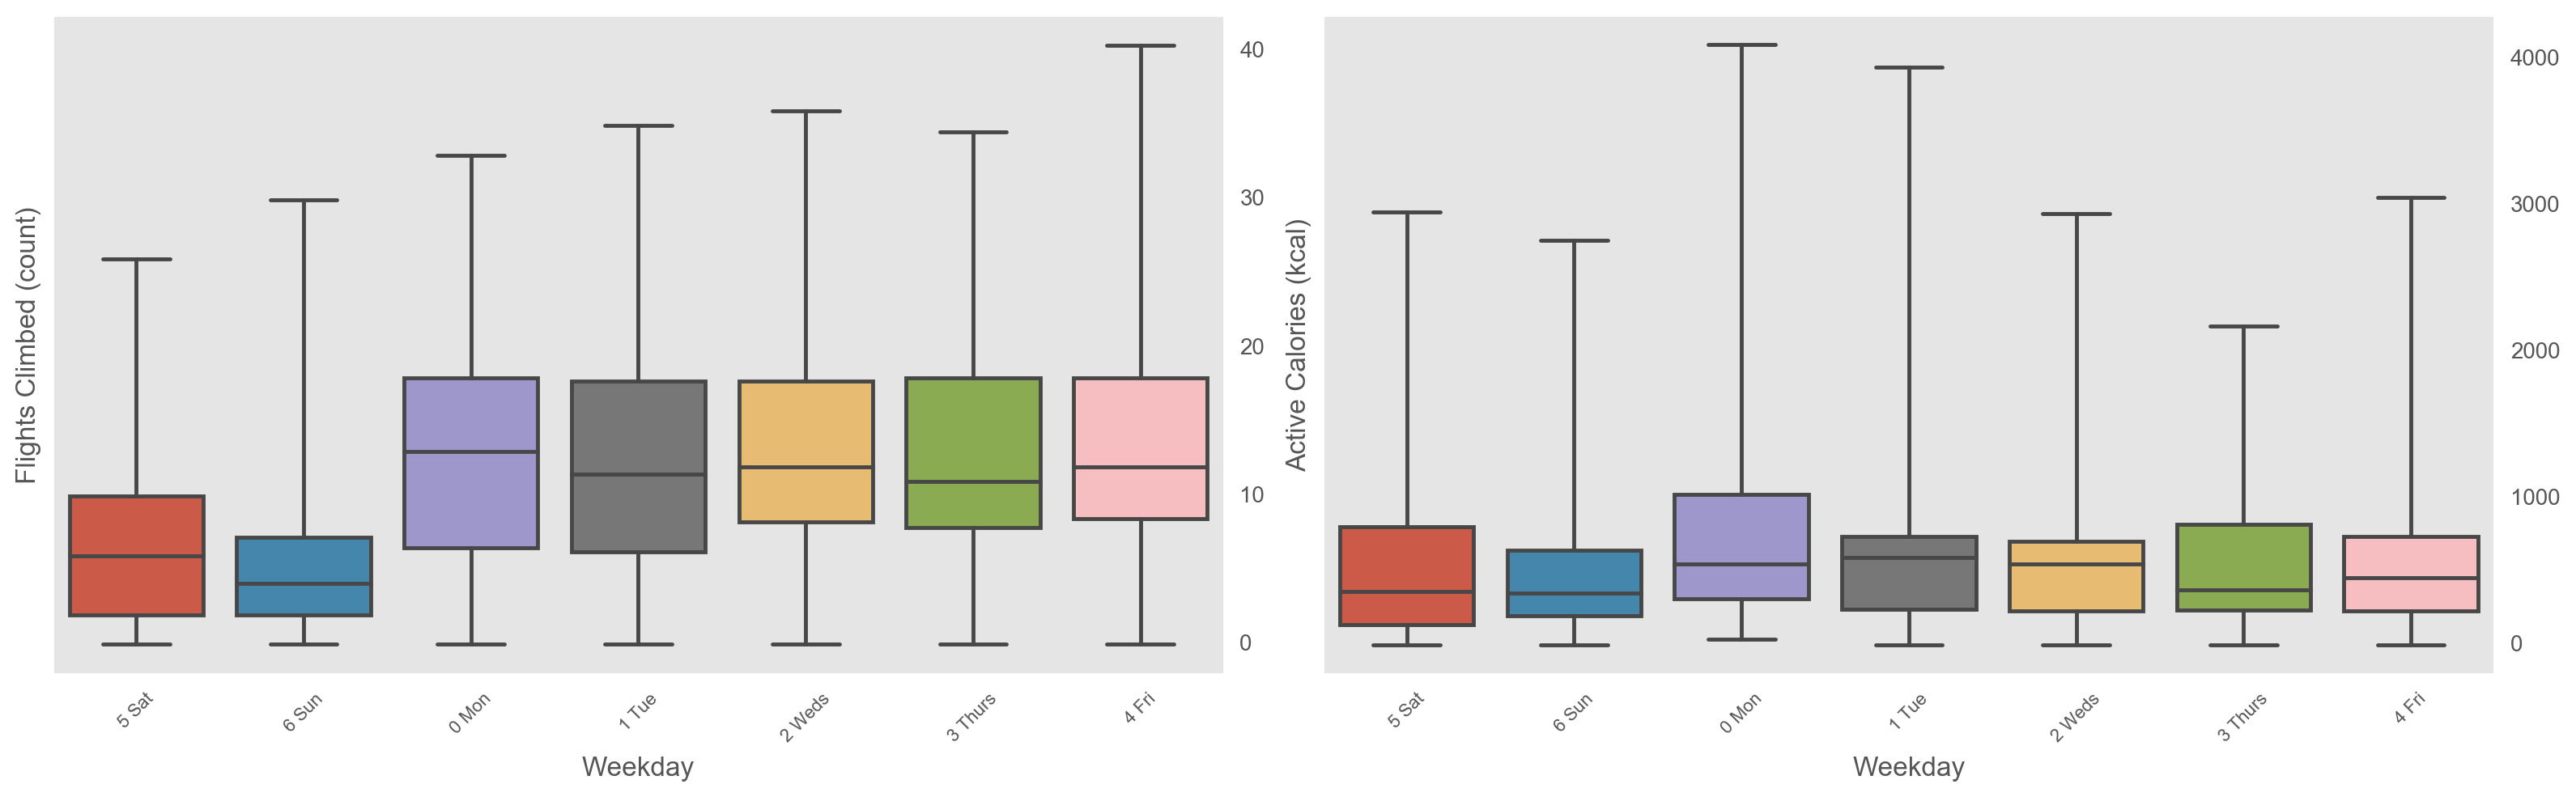

In [28]:
plt.figure(1,figsize=(16,5))
plt.subplot(121)
ax5 = sns.boxplot(x="Weekday", y="Distance (km)", data=data_for_steps, whis=[0,100],)
ax5.set_ylim(data_for_steps["Distance (km)"].min()-2,data_for_steps["Distance (km)"].max()+2)
ax5.set_xticklabels(data_for_steps['Weekday'].unique())
ax5.grid(b=False)
ax5.yaxis.tick_right()
labels = ax5.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=8)

plt.subplot(122)
ax5 = sns.boxplot(x="Weekday", y="Steps (count)", data=data_for_steps, whis=[0,100],)
ax5.set_ylim(data_for_steps["Steps (count)"].min()-200,data_for_steps["Steps (count)"].max()+200)
ax5.set_xticklabels(data_for_steps['Weekday'].unique())
ax5.grid(b=False)
ax5.yaxis.tick_right()
labels = ax5.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=8)

plt.figure(2,figsize=(16,5))
plt.subplot(121)
ax5 = sns.boxplot(x="Weekday", y="Total Calories (kcal)", data=data_for_cal, whis=[0,100],)
ax5.set_ylim(data_for_cal['Total Calories (kcal)'].min()-200,data_for_cal['Total Calories (kcal)'].max()+200)
ax5.set_xticklabels(data_for_cal['Weekday'].unique())
ax5.grid(b=False)
ax5.yaxis.tick_right()
labels = ax5.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=8)

plt.subplot(122)
ax5 = sns.boxplot(x="Weekday", y="Heart Rate (count/min)", data=data_for_hr, whis=[0,100],)
ax5.set_ylim(data_for_hr['Heart Rate (count/min)'].min()-2,data_for_hr['Heart Rate (count/min)'].max()+2)
ax5.set_xticklabels(data_for_hr['Weekday'].unique())
ax5.grid(b=False)
ax5.yaxis.tick_right()
labels = ax5.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=8)

plt.figure(3,figsize=(16,5))
plt.subplot(121)
ax5 = sns.boxplot(x="Weekday", y="Flights Climbed (count)", data=data_for_steps, whis=[0,100])
ax5.set_ylim(data_for_steps['Flights Climbed (count)'].min()-2,data_for_steps['Flights Climbed (count)'].max()+2)
ax5.set_xticklabels(data_for_steps['Weekday'].unique())
ax5.grid(b=False)
ax5.yaxis.tick_right()
labels = ax5.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=8)

plt.subplot(122)
ax5 = sns.boxplot(x="Weekday", y="Active Calories (kcal)", data=data_for_cal, whis=[0,100],)
ax5.set_ylim(data_for_cal['Active Calories (kcal)'].min()-200,data_for_cal['Active Calories (kcal)'].max()+200)
ax5.set_xticklabels(data_for_cal['Weekday'].unique())
ax5.grid(b=False)
ax5.yaxis.tick_right()
labels = ax5.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=8)

plt.tight_layout()
plt.show()